# Project1

### Todo
Jędrzej
1. Morphological operations:
    to denoise the imgage
    to connect the disconnected components in lines,
    Done but doesnt seem to have denoised or connected , the components, but i may try performing it on the thresholded picture
    andthat would probably be great
    or alternatively define some operations on neighbours, to close the shapes, and get rid of noise, like if 2 or less nieghbours delete
    if 1 or 2 neighbours only missing activate, itherwise leave. and could do several iterations - to do definitely

2. Think of another preprocessing techniques maybe
    skeletonization wont work, as the shapes are very fragmented
    DBSCAN is forbidden
3. check the best method on the another 2 files

    
Mateusz
1. Line detection , Hough_lines , Hough_lines_p
2. contour detection - Canny detector, 
3. Lines detection connected with contour detection

In [144]:
''''imports '''
import numpy as np
import math

import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from numpy.lib.stride_tricks import as_strided

### Data reading/creating

In [145]:


def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels





In [146]:
path_out = 'mateusz\\'
files = glob.glob(path_out+"*")
files.sort()




In [147]:
dx= 5.106500953873407 
dt= 0.0016


data_1 = []
data_2 = []
first_filename_1 = files[0]
first_filename_2 = files[6]
for file in files[:6]:
   data_1.append(np.load(file))
for file in files[6:]:
    data_2.append(np.load(file))


data_1 = np.concatenate(data_1)
data_2 = np.concatenate(data_2)
time_start_1 = datetime.datetime.strptime('2024-05-07 ' + first_filename_1.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
time_start_2 = datetime.datetime.strptime('2024-05-07 ' + first_filename_2.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")

index_1 = pd.date_range(start=time_start_1, periods=len(data_1), freq=f'{dt}s')
index_2 = pd.date_range(start=time_start_2, periods=len(data_1), freq=f'{dt}s')


columns_1 = np.arange(len(data_1[0])) * dx
columns_2 = np.arange(len(data_2[0])) * dx


df_1 = pd.DataFrame(data=data_1, index=index_1, columns=columns_1)
df_2 = pd.DataFrame(data=data_2, index=index_2, columns=columns_2)




### Data preprocessing functions

In [148]:
'''converting to 0-255 int to be able to use opencv functions for image preprocessing'''
def convert_to_img_format(df,ret_dataframe=True):
    data = df.to_numpy()
    data = np.floor(data *255)
    data = data.astype(np.uint8)
    if ret_dataframe:
        return pd.DataFrame(data, index=df.index, columns=df.columns)
    else:
        return data

In [149]:
'''downsampling since the resolution of the image is 37500 x 52 so it could be difficult for the line detection to work, the line can be scattered
vertically  ,probably some kind
of the time dimension downsampling shall be performed'''




def downsampling_time_mean(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute mean
    downsampled_data = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)


    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data


def downsampling_time_median(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.median(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    
def downsampling_time_max(df,window_size=10,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    
def downsampling_time_max_mean(df,window_size=10,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data_max = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)
    downsampled_data_mean = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)
    downsampled_data = downsampled_data_max - downsampled_data_mean

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    


In [150]:
def thresholding_otsu_function(df, ret_dataframe = True):
        data = df.to_numpy()
        data= data.astype(np.uint8)
        thresh, image = cv2.threshold(
        data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
        if ret_dataframe:
                return pd.DataFrame(image,index = df.index, columns = df.columns)
        else:
                return image
        
def thresholding_adaptive_function(df,blocksize=101,constant=2,ret_dataframe = True):
        data = df.to_numpy()
        data= data.astype(np.uint8)
        image = cv2.adaptiveThreshold(
        data, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,blocksize,constant
)
        if ret_dataframe:
                return pd.DataFrame(image,index = df.index, columns = df.columns)
        else:
                return image
        
def thresholding_adaptive_gaussian_function(df,blocksize=101,constant=2,ret_dataframe = True):
        data = df.to_numpy()
        data= data.astype(np.uint8)
        image = cv2.adaptiveThreshold(
        data, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,blocksize,constant
)
        if ret_dataframe:
                return pd.DataFrame(image,index = df.index, columns = df.columns)
        else:
                return image



In [151]:
'''name being the blurring function but may also be a vertical aggregation function bcs when the kernel is for example (11,1) then it
is just an aggregation of 11 cells , 5 above given cell and 5 below '''
def blurring_function(df,kernel_size=5, gaussian = True,ret_dataframe = True):
    print(type(df))
    if gaussian:
        data_blurred = cv2.GaussianBlur(df.to_numpy(),kernel_size,0)
    else:
        kernel = np.ones((kernel_size[0],kernel_size[1]))*(1/(kernel_size[0]*kernel_size[1]))
        data_blurred = cv2.filter2D(src=df.to_numpy(),kernel=kernel,ddepth=-1)
    if ret_dataframe:
        return pd.DataFrame(data_blurred, index=df.index, columns=df.columns)
    else:
        return data_blurred


In [152]:



def basic_preprocessing(df, minmax=False,ret_dataframe=False):
    """
    Preprocesses a DataFrame by centering, taking absolute values,
    clipping outliers, and optionally applying min-max scaling.

    Parameters:
        df (pd.DataFrame): Input DataFrame to preprocess.
        minmax (bool): If True, applies min-max scaling to the data.

    Returns:
        pd.DataFrame: A new DataFrame with altered data, preserving the original index and columns.
    """
    # Make a copy of the input DataFrame to avoid modifying it
    new_df = df.copy()
    
    # Center the data by subtracting the mean
    new_df -= new_df.mean()
    
    # Take the absolute value
    new_df = np.abs(new_df)
    
    # Clip outliers at the 3rd and 99th percentiles
    low, high = np.percentile(new_df.values, [3, 99])  # Use .values to apply percentiles to the entire data
    
    new_df = np.clip(new_df, low, high)
    
    # Apply min-max scaling if specified
    if minmax:
        new_df = (new_df - low) / (high - low)
        new_df[new_df < 0] = 0  # Ensure lower values are clipped correctly

    # Return as DataFrame to preserve structure
    if ret_dataframe:
        return pd.DataFrame(new_df, index=df.index, columns=df.columns)
    else:
        numpy_array = new_df.to_numpy()
        return numpy_array

### Morphologic operations

In [153]:

def get_structuring_element(kernel):
    """
    Generate a structuring element based on the kernel input:
    - If int, creates a square structuring element (kernel, kernel).
    - If tuple, creates a rectangular structuring element (kernel[0], kernel[1]).
    - If already a structuring element, returns it as is.
    """
    if isinstance(kernel, int):
        return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel, kernel))
    elif isinstance(kernel, tuple):
        return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel[1], kernel[0]))
    elif isinstance(kernel, np.ndarray):  # Assume it's already a structuring element
        return kernel
    else:
        raise ValueError("Kernel must be an int, tuple, or a valid structuring element (numpy array).")





def morphological_opening(image, kernel):
    """Standard morphological opening (erosion followed by dilation)."""
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphological_closing(image, kernel):
    """Standard morphological closing (dilation followed by )."""
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


def proper_opening(image, kernel,ret_dataframe=True):
    """
    Proper opening: Q(f) = min(f, C(O(C(f))))
    as was on classes

    """
    
    img = image.to_numpy()
    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[1], kernel[0]))

    kernel = get_structuring_element(kernel)
    
    
    # Standard closing followed by opening
    closing = morphological_closing(img, kernel)
    opening = morphological_opening(closing, kernel)
    second_closing = morphological_closing(opening, kernel)

    # Proper opening: min(original, second_closing)
    proper_opened = np.minimum(img, second_closing)
    if ret_dataframe:
        return pd.DataFrame(proper_opened, index=image.index, columns=image.columns)
    else:
        return proper_opened

def proper_closing(image, kernel,ret_dataframe=True):
    """
    Proper closing: G(f) = max(f, O(C(O(f))))
    as was on classes
    """
    img = image.to_numpy()
    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[1], kernel[0]))

    kernel = get_structuring_element(kernel)
    
    # Standard opening followed by closing
    opening = morphological_opening(img, kernel)
    closing = morphological_closing(opening, kernel)
    second_opening = morphological_opening(closing, kernel)

    # Proper closing: max(original, second_opening)
    
    proper_closed = np.maximum(img, second_opening)
    
    if ret_dataframe:
        return pd.DataFrame(proper_closed, index=image.index, columns=image.columns)
    else:
        return proper_closed
def dilate(image, kernel, kernel_shape=cv2.MORPH_RECT,ret_dataframe=True):
    """
    Perform morphological dilation on binary image
    """
    img = image.to_numpy()

    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(kernel_shape, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[1]))

    kernel = get_structuring_element(kernel)

    dilated_image = cv2.dilate(img, kernel)
    if ret_dataframe:
        return pd.DataFrame(dilated_image, index=image.index, columns=image.columns)
    else:
        return dilated_image



def erode(image, kernel=3, kernel_shape=cv2.MORPH_RECT,ret_dataframe=True):
    """
    Perform morphological erosion on binary image 

    """
    img = image.to_numpy()
    # if len(kernel)==1:
    #     kernel = cv2.getStructuringElement(kernel_shape, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[1]))

    kernel = get_structuring_element(kernel)

    eroded_image = cv2.erode(img, kernel)
    
    if ret_dataframe:
        return pd.DataFrame(eroded_image, index=image.index, columns=image.columns)
    else:
        return eroded_image


def continous_dilation(image, structuring_element,ret_dataframe):
    """
    Perform continuous domain dilation on normal image like [0-255] range.
    """
    img = image.to_numpy()
    
    if len(structuring_element.flatten()) >2:
        kernel_h, kernel_w = structuring_element.shape  # Get kernel dimensions
    else:
        kernel_h, kernel_w = structuring_element[0], structuring_element[1]

   
    # Padding the image to handle boundaries
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # Define the shape and strides for the sliding window
    shape_strided = (
        img.shape[0], img.shape[1], kernel_h, kernel_w
    )
    strides = padded_image.strides + padded_image.strides
    
    # Create sliding window view
    image_strides = as_strided(padded_image, shape_strided, strides)
    
    # Perform dilation (max operation over the window)
    image_return = np.max(image_strides, axis=(2, 3))

    if ret_dataframe:
        return pd.DataFrame(image_return, index=image.index, columns=image.columns)
    else:
        return image_return
    
    
    

def continous_erosion(image, structuring_element,ret_dataframe=True):
    """
    Perform continuous domain erosion same as continous dilation but minimum of sliding window instead of maximum taken.

    """
    img = image.to_numpy()
    if len(structuring_element.flatten()) >2:
        kernel_h, kernel_w = structuring_element.shape  # Get kernel dimensions
    else:
        kernel_h, kernel_w = structuring_element[0], structuring_element[1]
    
    # Padding the image to handle boundaries
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # Define the shape and strides for the sliding window
    shape_strided = (
        img.shape[0], img.shape[1], kernel_h, kernel_w
    )
    strides = padded_image.strides + padded_image.strides
    
    # Create sliding window view
    image_strides = as_strided(padded_image, shape_strided, strides)
    
    # Perform dilation (max operation over the window)
    image_return = np.min(image_strides, axis=(2, 3))
    
    if ret_dataframe:
        return pd.DataFrame(image_return, index=image.index, columns=image.columns)
    else:
        return image_return

def automedian(image, kernel,ret_dataframe=True):
    """
    Automedian filter: A(f) = max(O(C(O(f))), Q(f))
    as was on the clasees
    """
    img = image.to_numpy()
    
    
    # Step 1: O(C(O(f)))
    kernel = get_structuring_element(kernel)
    opening = morphological_opening(img, kernel)
    closing_after_opening = morphological_closing(opening, kernel)
    second_opening = morphological_opening(closing_after_opening, kernel)
    
    # Step 2: Q(f)
    proper_opened = proper_opening(image, kernel=kernel)
    
    # Step 3: A(f) = max(O(C(O(f))), Q(f))
    automedian_filtered = np.maximum(second_opening, proper_opened)
    
    if ret_dataframe:
        return pd.DataFrame(automedian_filtered, index=image.index, columns=image.columns)
    else:
        return automedian_filtered
    

def create_diag_kernel(size,bottom_top=True):
    '''creating diagonale kernel maybe useuful for diagonla line detection? '''
    kernel = np.zeros(size, dtype=np.uint8)  # Initialize kernel with zeros

    rows, cols = size
    mid_row, mid_col = rows // 2, cols // 2

    if bottom_top:
        # Fill bottom-left and top-right
        kernel[:mid_row, mid_col:] = 1  # Top-right
        kernel[mid_row:, :mid_col] = 1  # Bottom-left
    else:
        # Fill top-left and bottom-right
        kernel[:mid_row, :mid_col] = 1  # Top-left
        kernel[mid_row:, mid_col:] = 1  # Bottom-right
    return kernel


    




### Plotting functions

In [154]:



def plot_continuous_histogram(data, number_of_kernels=50):
    """
    Plots a continuous histogram (distribution) of values from a 2D NumPy array
    with customizable bin width and zoom range.

    Parameters:
        data (numpy.ndarray): 2D NumPy array of float64 values.
        bin_width (float): Desired width of bins for the histogram. Defaults to auto.
        zoom_range (tuple): Optional (min, max) range to zoom in on x-axis.
    """
    if not isinstance(data, np.ndarray):
        raise TypeError("Input data must be a NumPy array.")
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D NumPy array.")
    
    # Flatten the 2D array into 1D
    flattened_data = data.flatten()
    
    # Remove NaN or infinite values, if any
    flattened_data = flattened_data[np.isfinite(flattened_data)]
    
    # Optionally zoom in on a specific range
    
    # Compute the kernel density estimate for smoother distribution
    kde = gaussian_kde(flattened_data)
    
    # Determine x-axis range and binning
    min_val, max_val = flattened_data.min(), flattened_data.max()
    x_vals = np.linspace(min_val, max_val, number_of_kernels)
    y_vals = kde(x_vals)
    
    # Adjust bin width
    
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, y_vals, label='Data density estimation', color='blue')
    #plt.hist(flattened_data, bins=bins, density=True, alpha=0.5, color='orange', label='Histogram')
    plt.title('Continuous Histogram of 2D Array Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [155]:
'''the default plotting function'''
def plotting_function(df,to_preprocess =False):
        fig = plt.figure(figsize=(12,16))
        ax = plt.axes()

        new_df = df.copy()
        if to_preprocess:
                new_df = basic_preprocessing(df,minmax=False,ret_dataframe=True)

        low, high = np.percentile(new_df, [3, 99]) 
        norm = Normalize(vmin=low, vmax=high, clip=True)
        
        # This is an example transformation and should be converted to the proper algorithm
        


        im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
        plt.ylabel('time')
        plt.xlabel('space [m]')

        cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        x_positions, x_labels = set_axis(df.columns)
        ax.set_xticks(x_positions, np.round(x_labels))
        y_positions, y_labels = set_axis(new_df.index.time)
        ax.set_yticks(y_positions, y_labels)
        plt.show()
 
    

# Tests

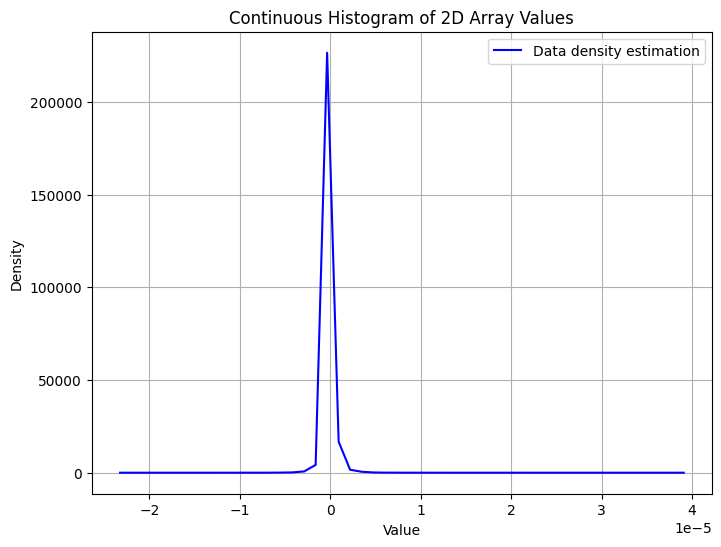

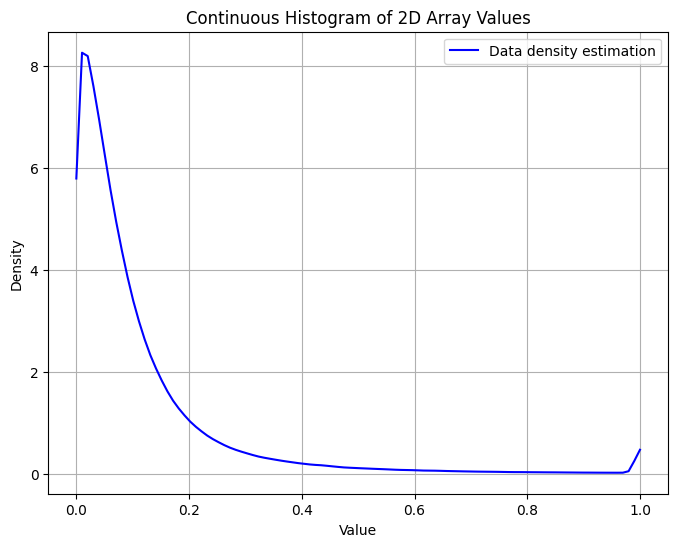

In [156]:
'''estimating the distribution of the data'''
''''comparison of the data distirbution before basic preprocessing and after'''
'''before preprocessing '''
plot_continuous_histogram(data_1)
'''after preprocessing'''
data_1_preprocessed = basic_preprocessing(df_1,minmax=True,ret_dataframe=False)
plot_continuous_histogram(data_1_preprocessed,number_of_kernels=100)


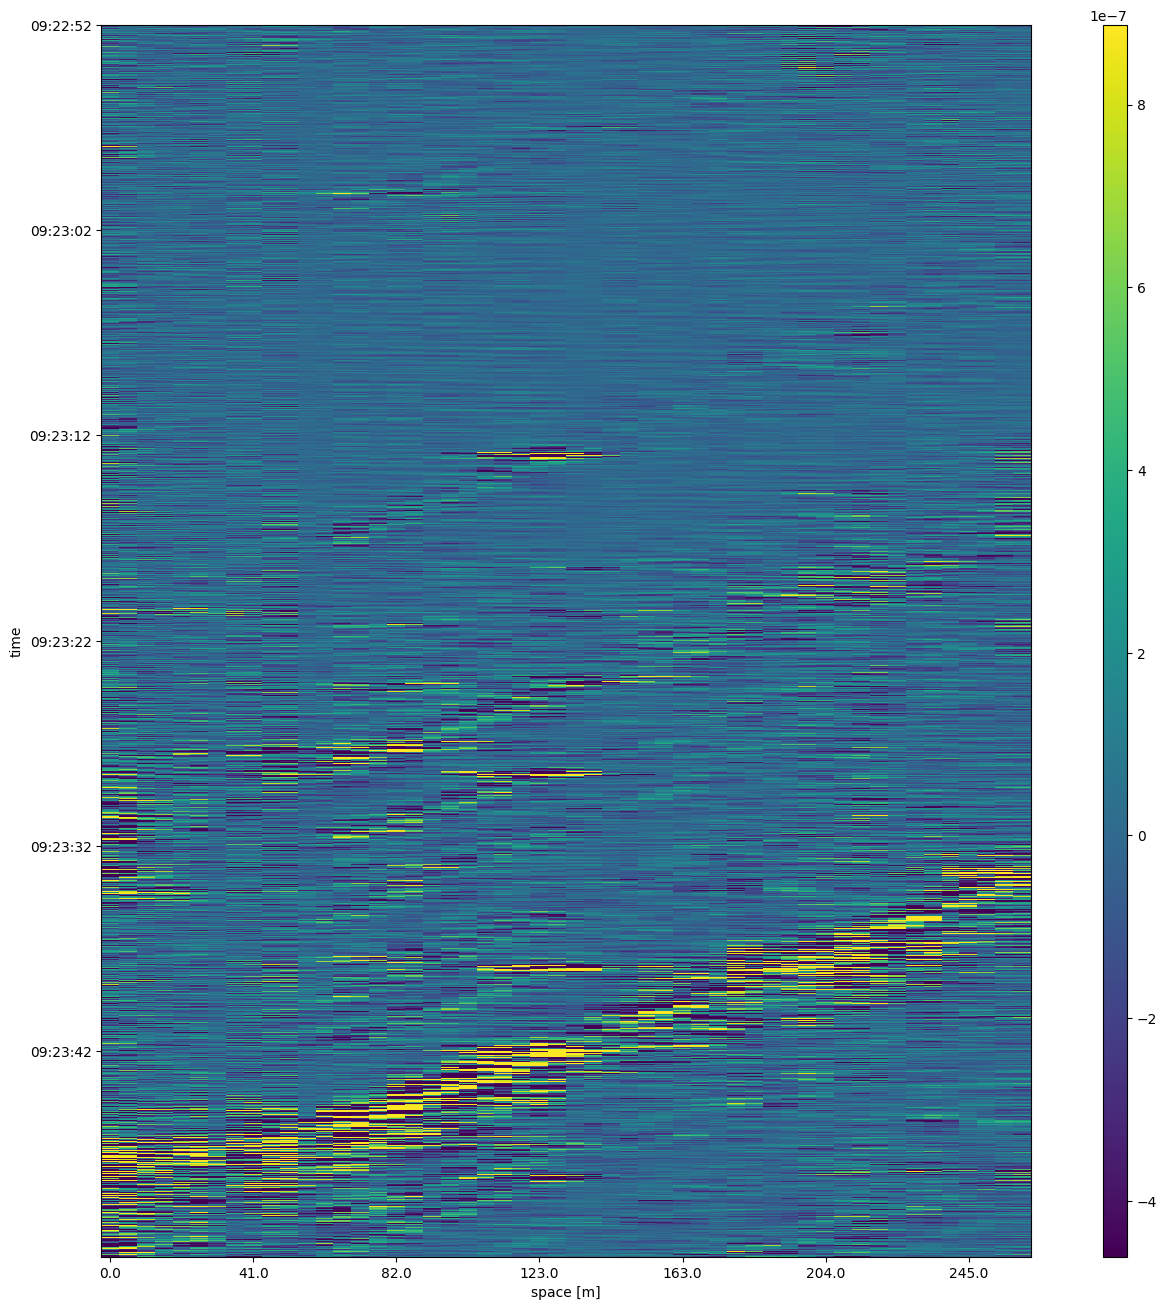

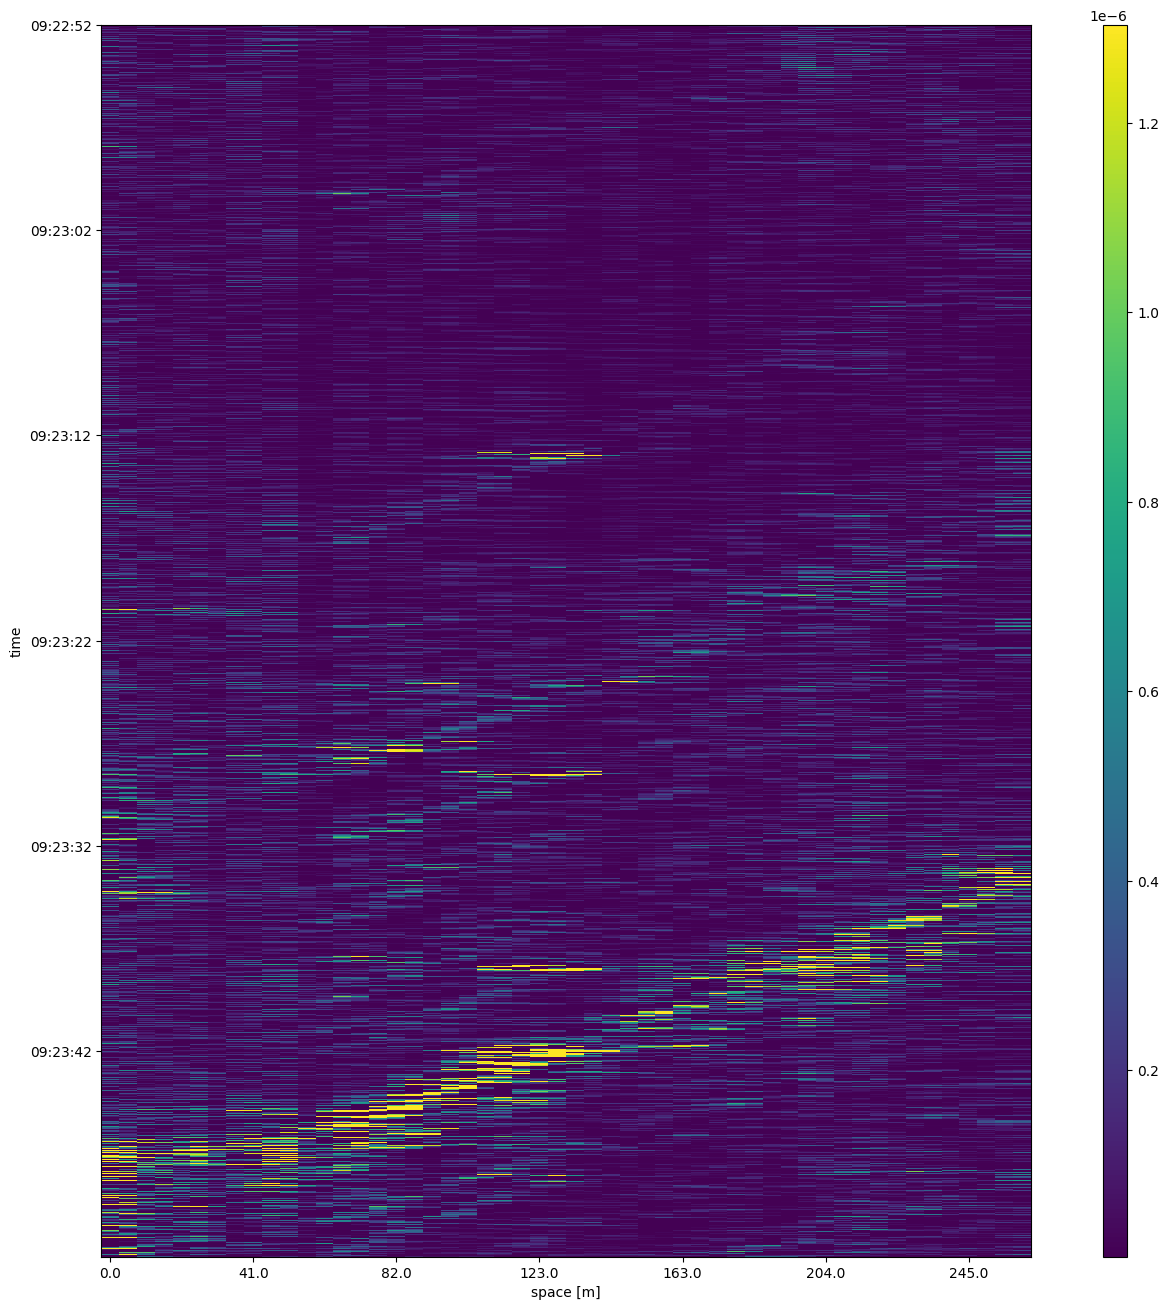

In [157]:
'''comparison of unpreprocessed with the basic preprocessing of the image'''
plotting_function(df_1,to_preprocess=False)  
plotting_function(df_1,to_preprocess=True)


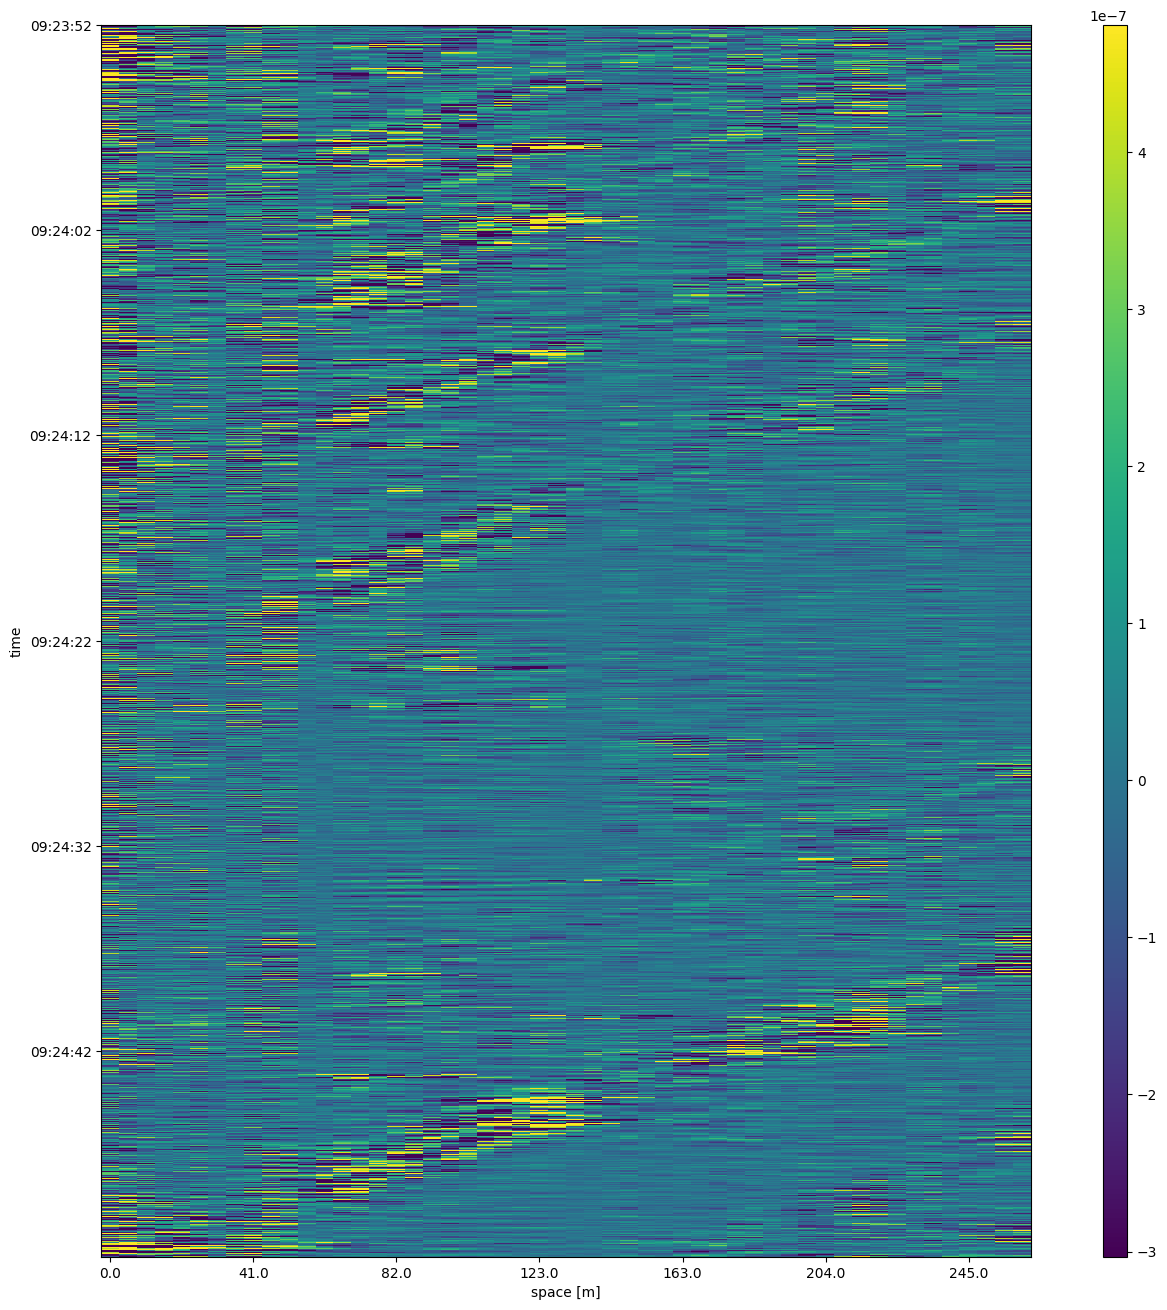

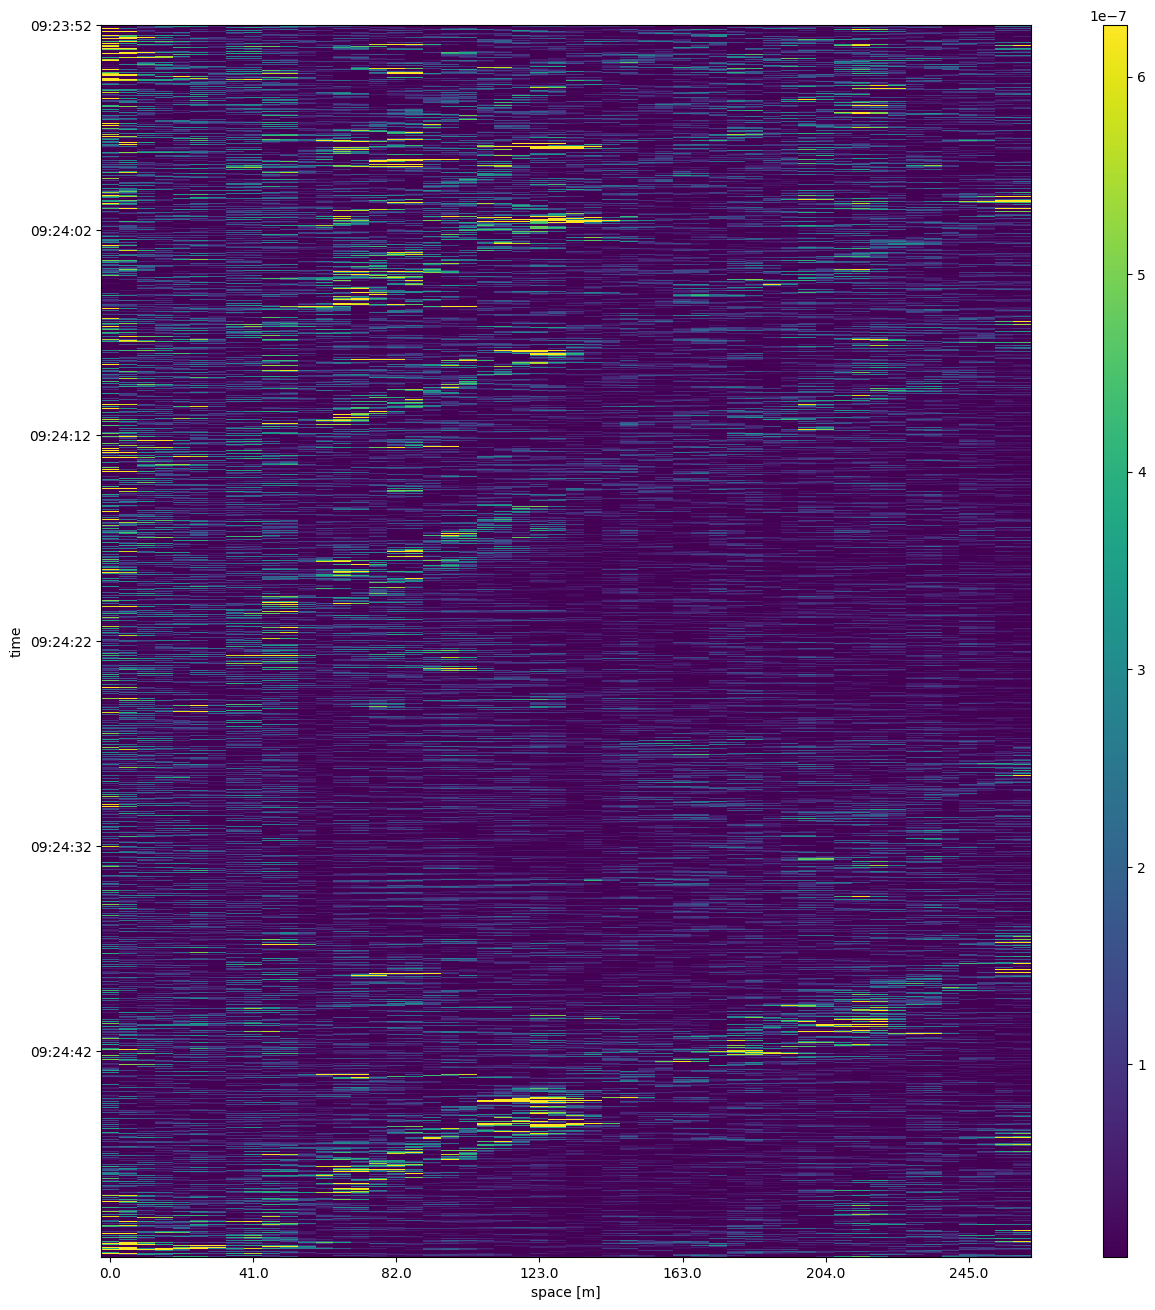

In [158]:
'''the 'image' before and after the basic preprocessing'''
plotting_function(df_2,to_preprocess=False)
plotting_function(df_2 ,to_preprocess=True)

<class 'pandas.core.frame.DataFrame'>


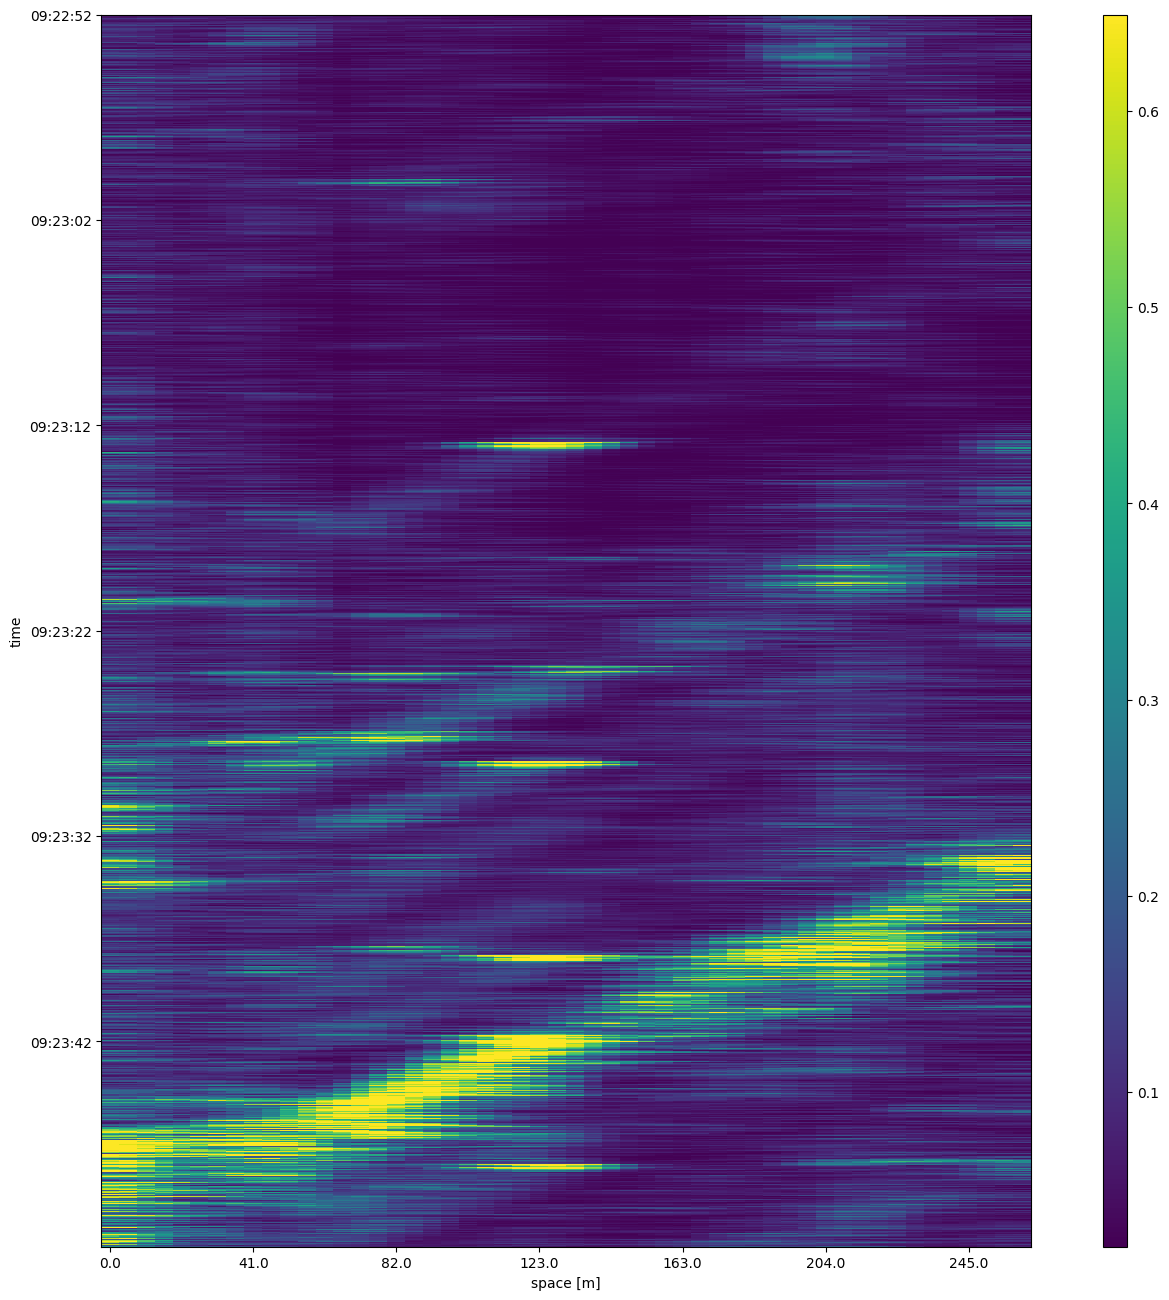

<class 'pandas.core.frame.DataFrame'>


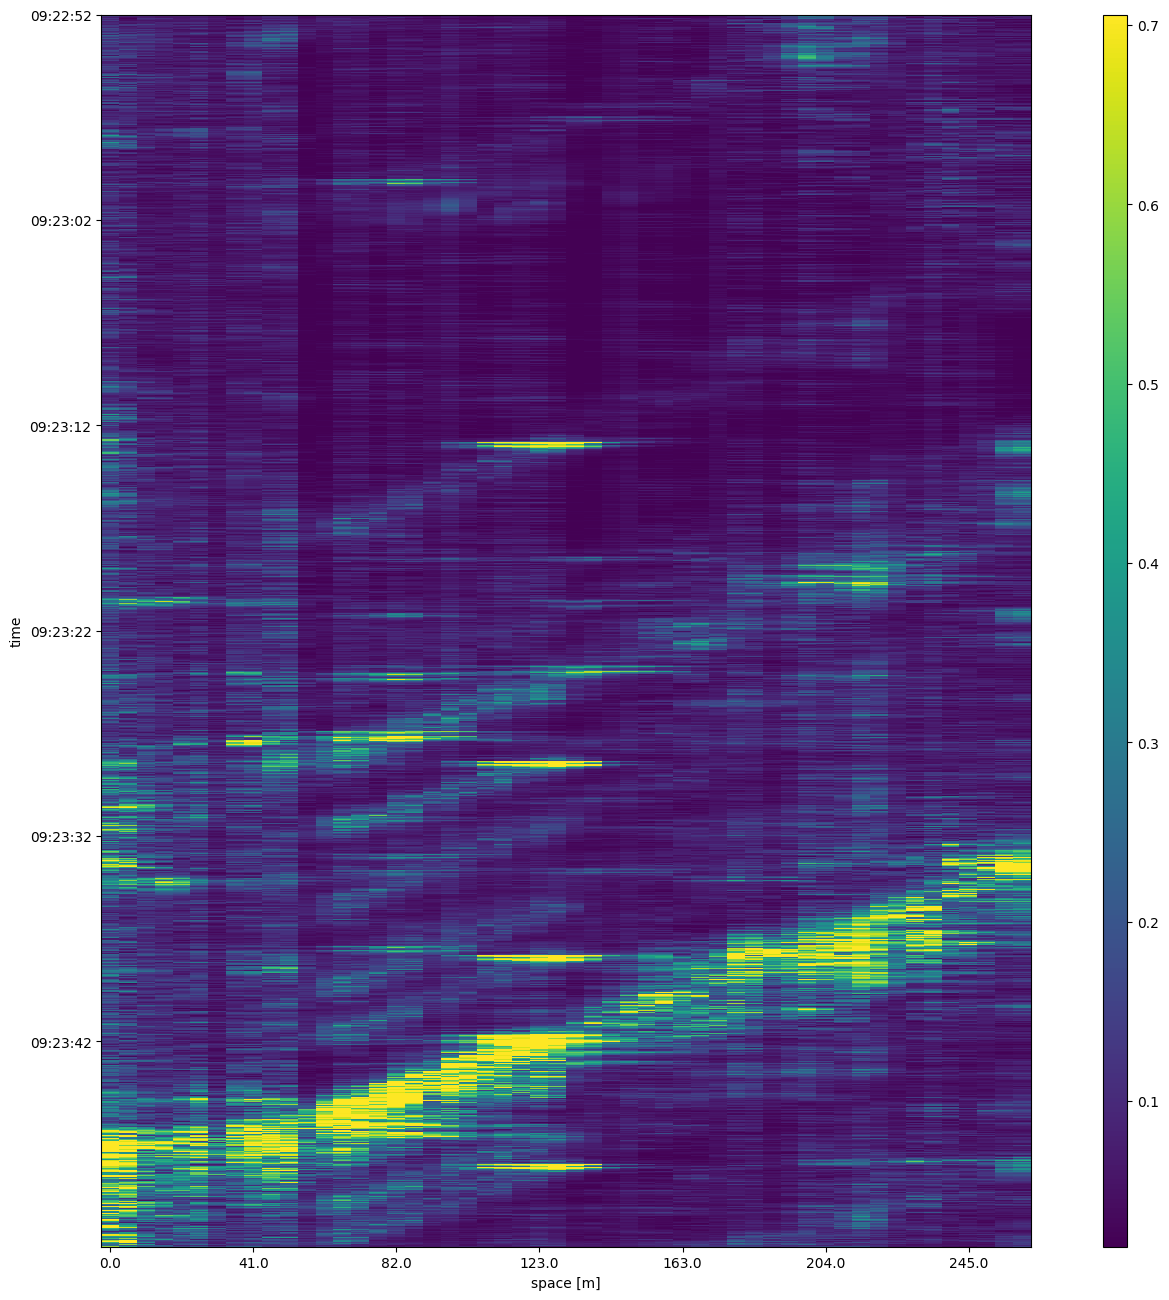

<class 'pandas.core.frame.DataFrame'>


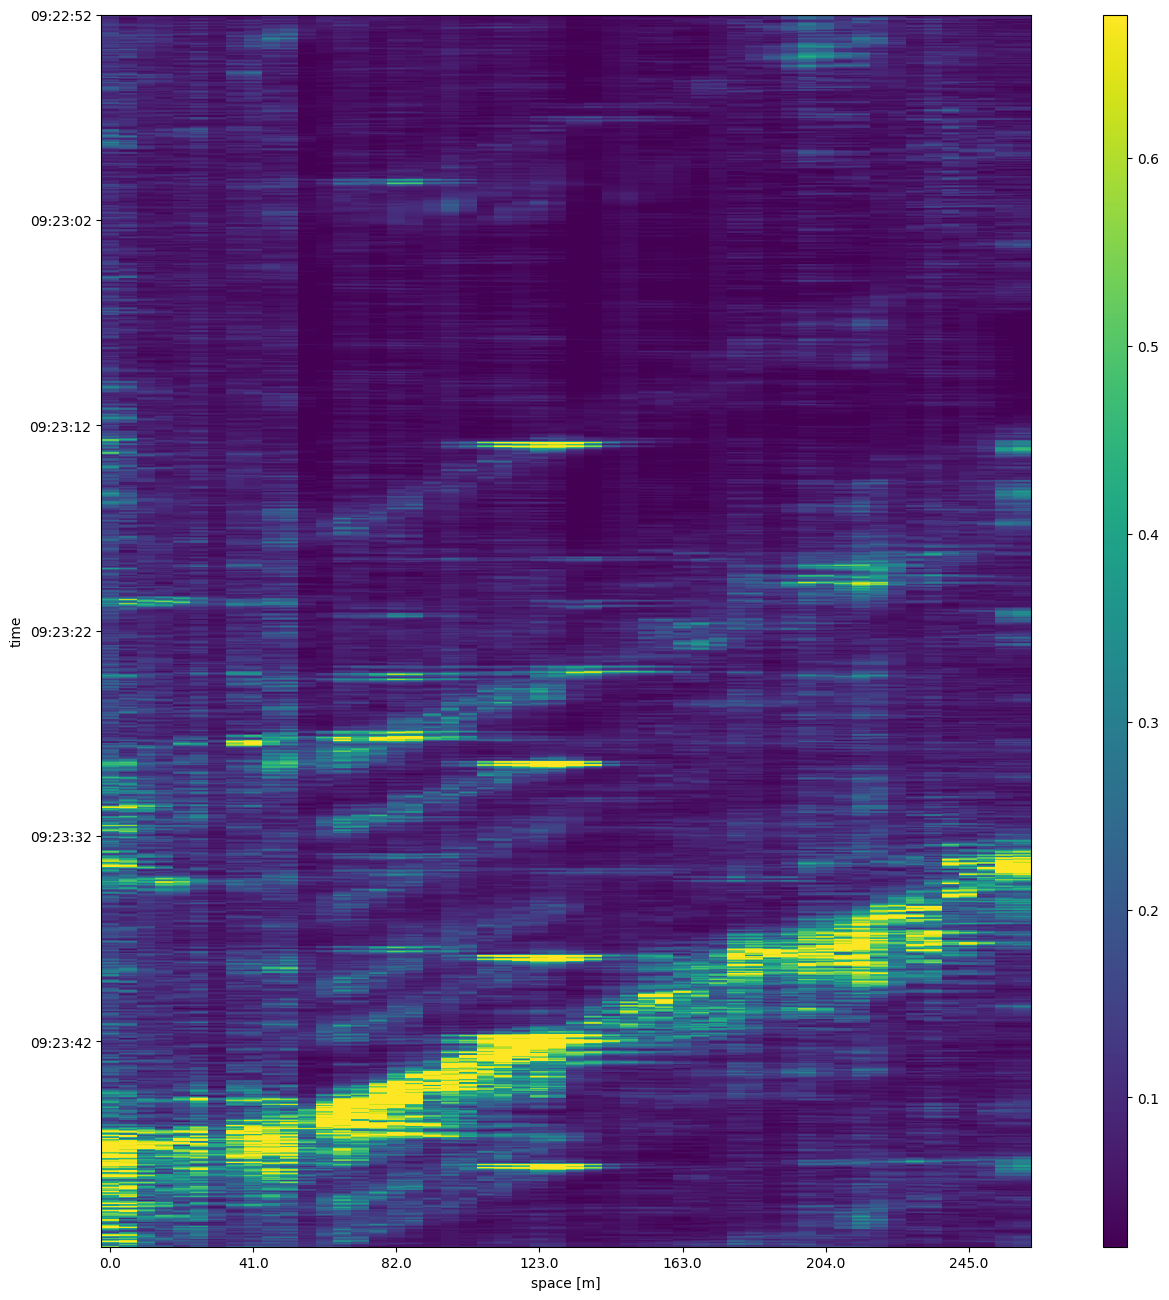

<class 'pandas.core.frame.DataFrame'>


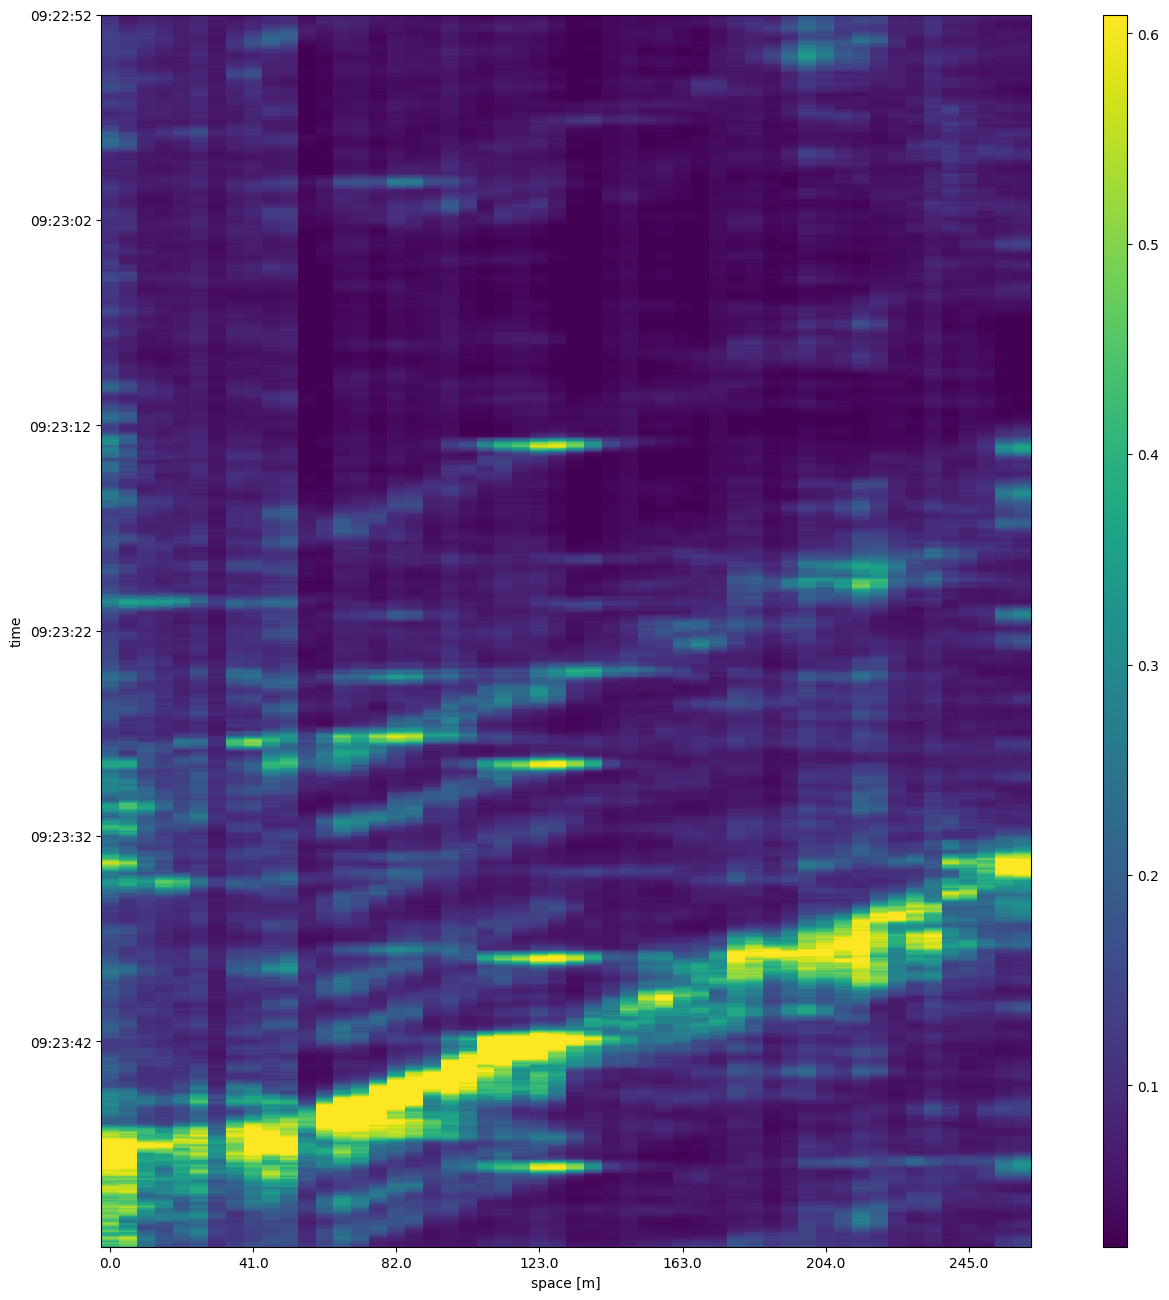

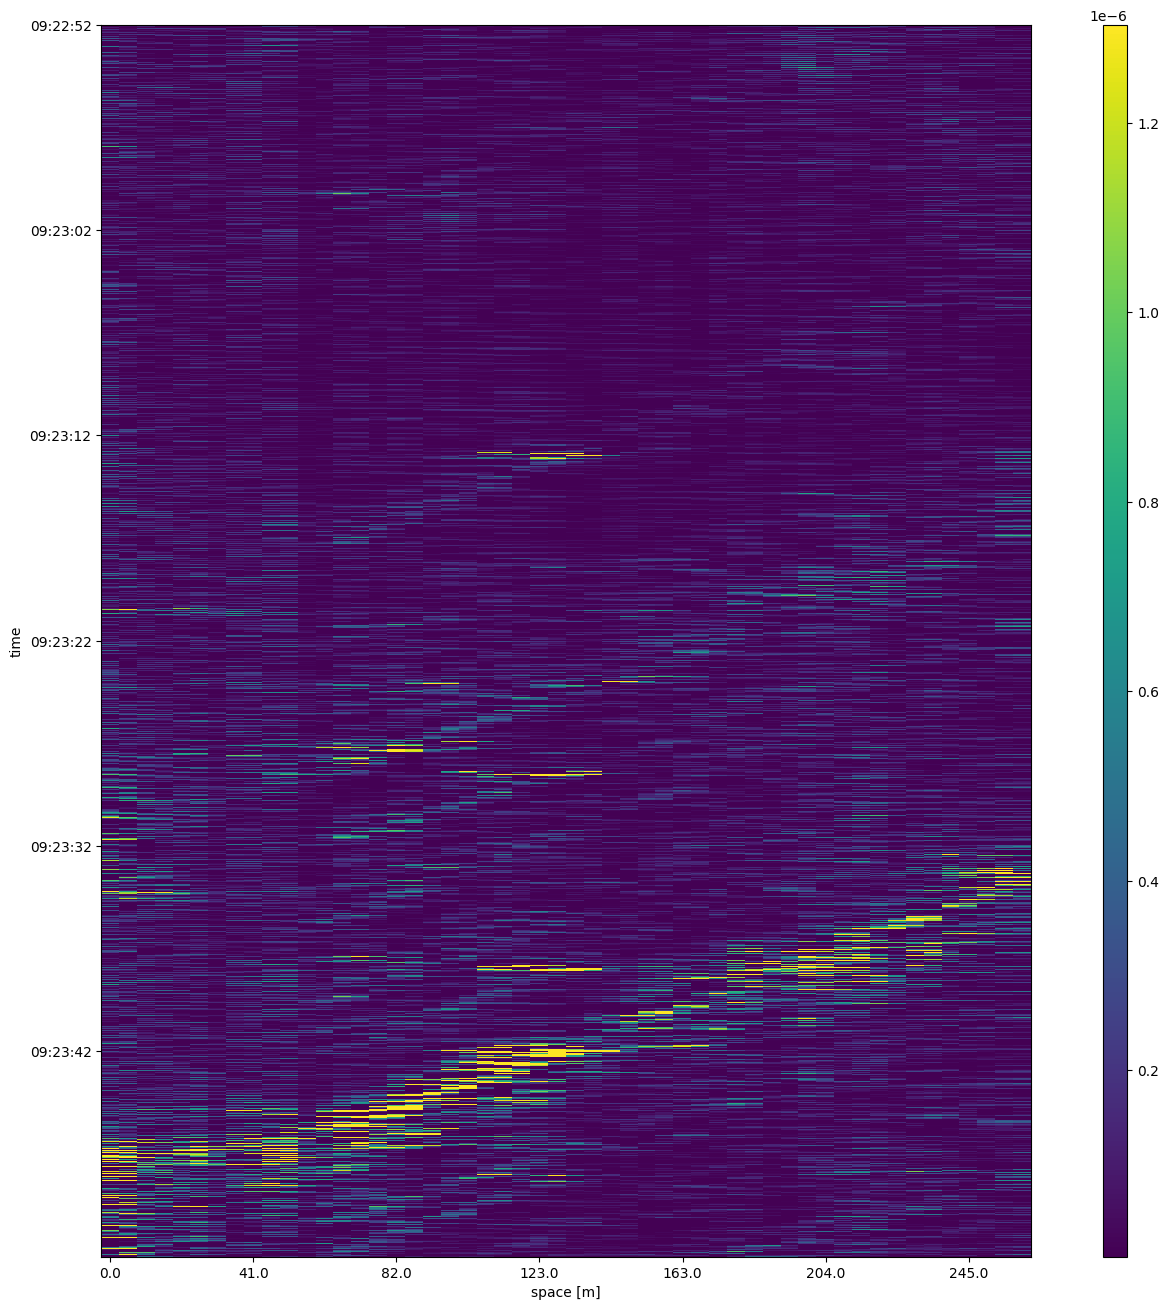

In [159]:
'''checking out  preprocessing methods, '''

'''basic preprocessing'''
data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blur filter with square kernel taking place , however it seem not to work'''
data_1_blurred = blurring_function(data_1_preprocessed,(5,5),False,True)
plotting_function(data_1_blurred,to_preprocess=False)

'''here for each pixel the mean taken with 12 vertical neighbours to the top of it and 12 vertical neighbours to the bottom, seem to make sense '''
data_2_blurred = blurring_function(data_1_preprocessed,(25,1),False,True)
plotting_function(data_2_blurred,to_preprocess=False)

'''here the same operation as previously but  even with bigger vertcial 'window'''
data_3_blurred = blurring_function(data_1_preprocessed,(51,1),False,True)
plotting_function(data_3_blurred,to_preprocess=False)

data_4_blurred = blurring_function(data_1_preprocessed,(301,1),False,True)
plotting_function(data_4_blurred)


''''plotting the normal image for comparison '''
plotting_function(df_1,to_preprocess=True)

#### time downsampling

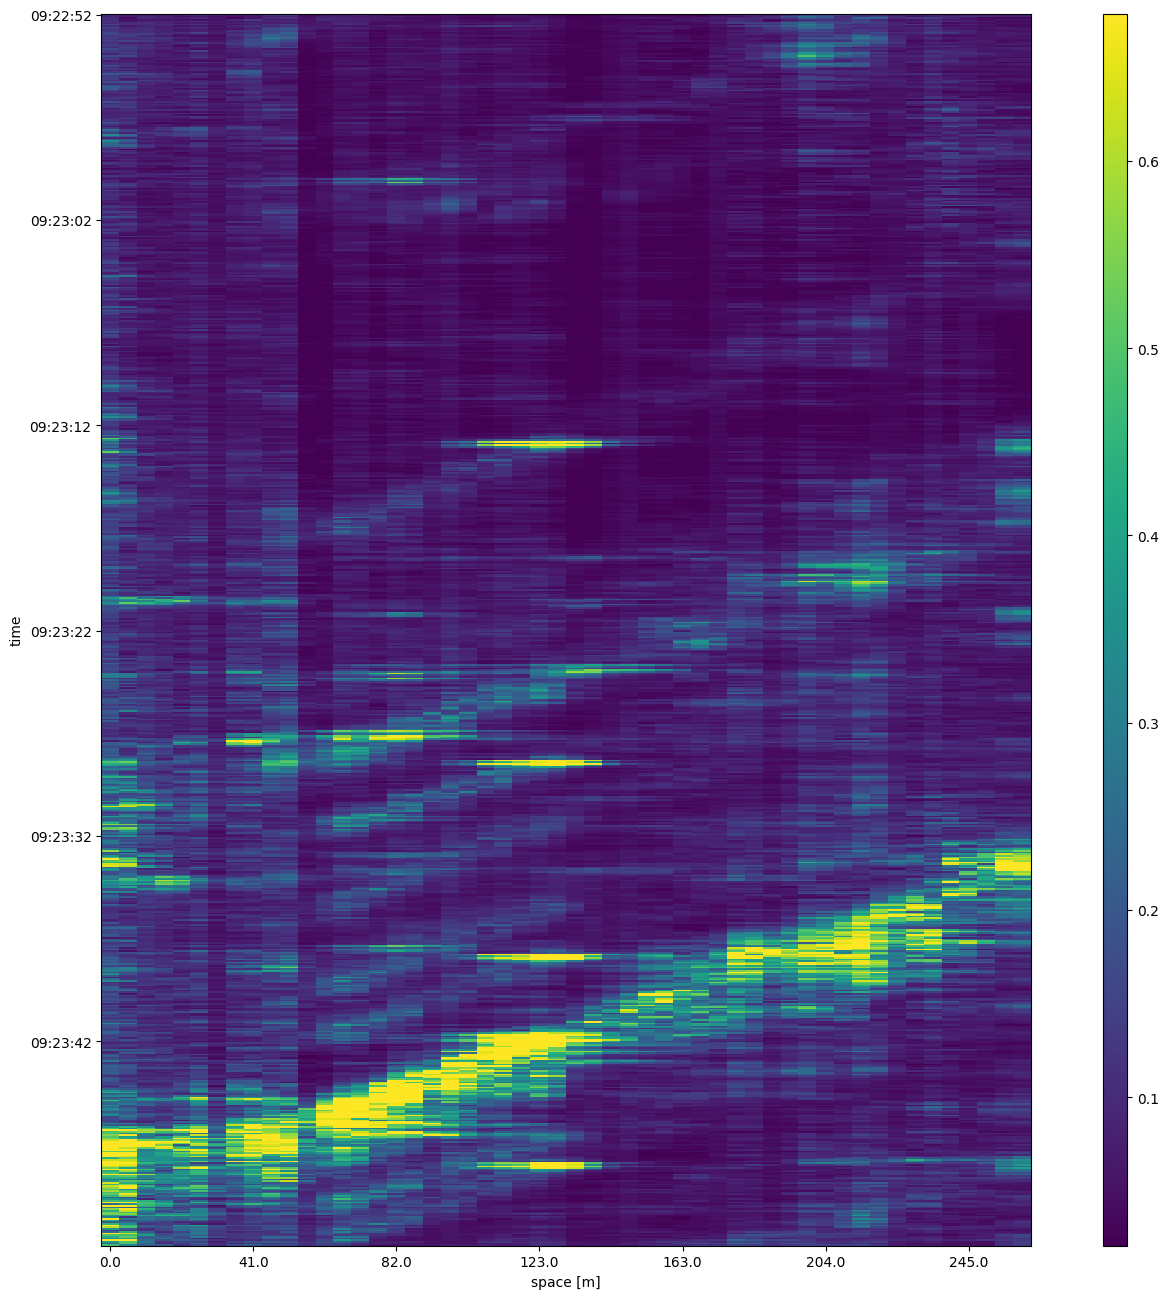

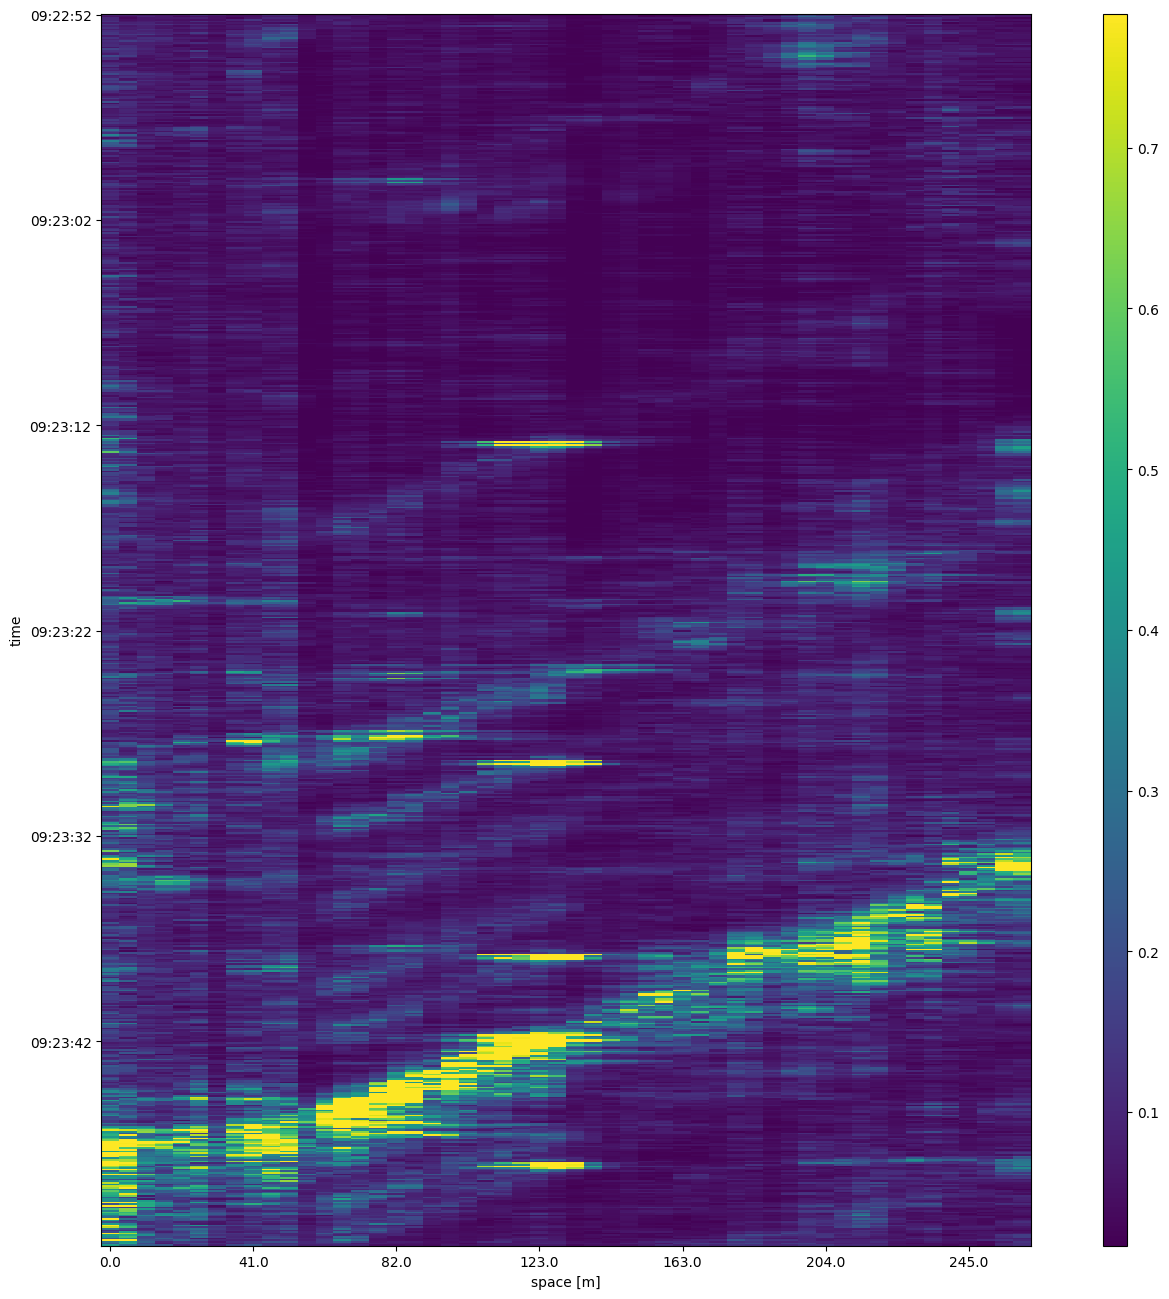

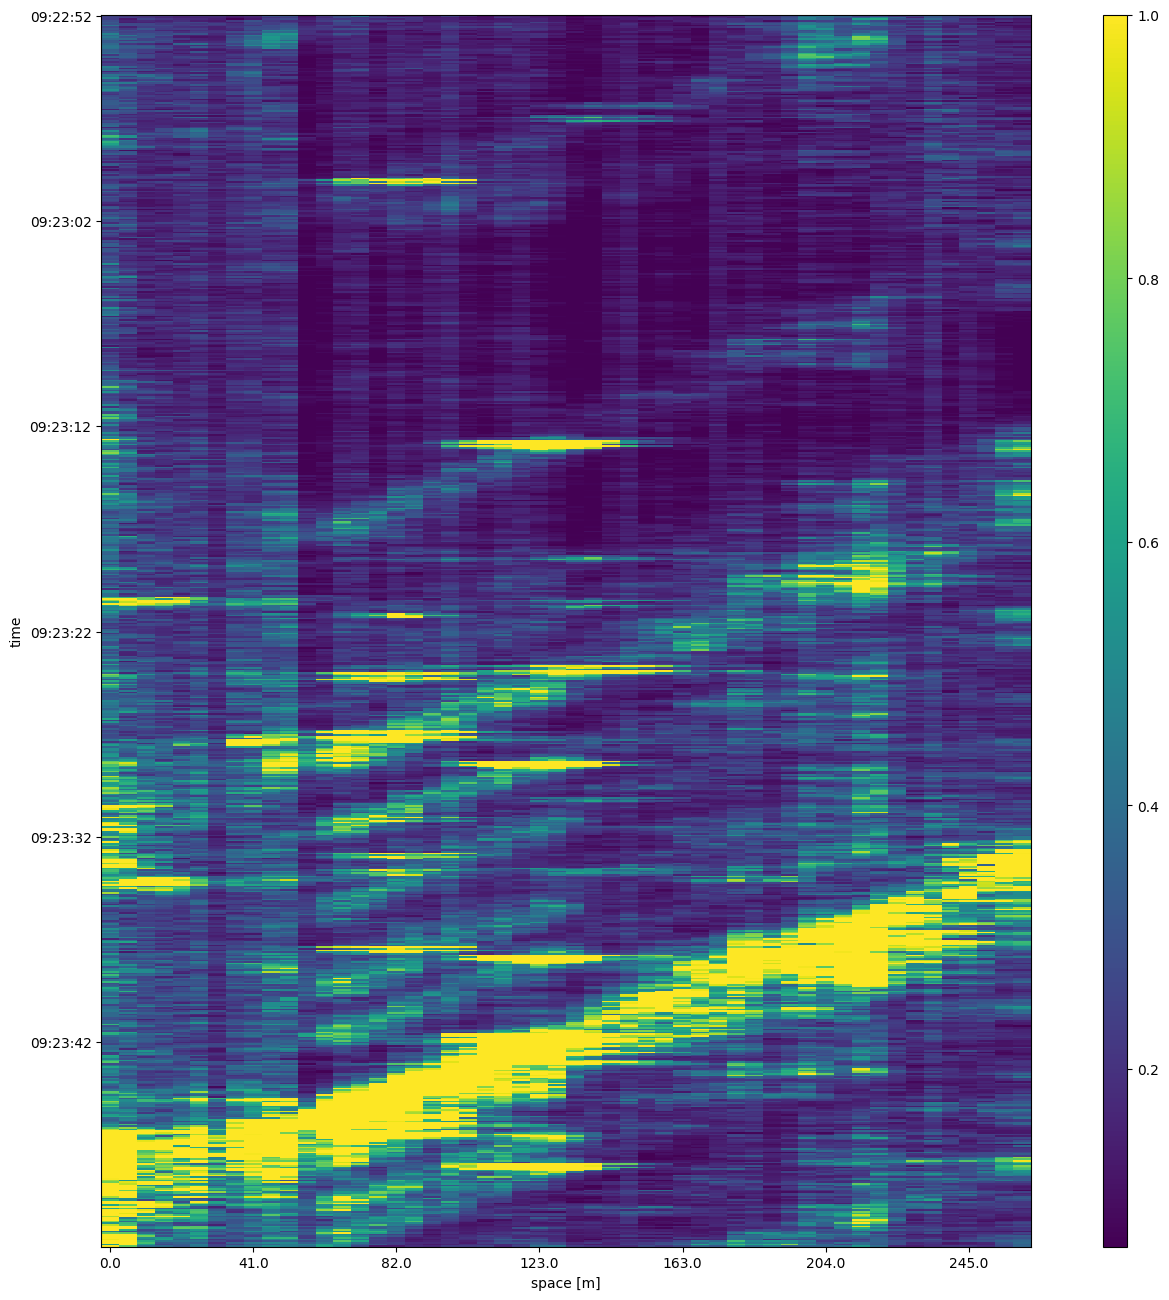

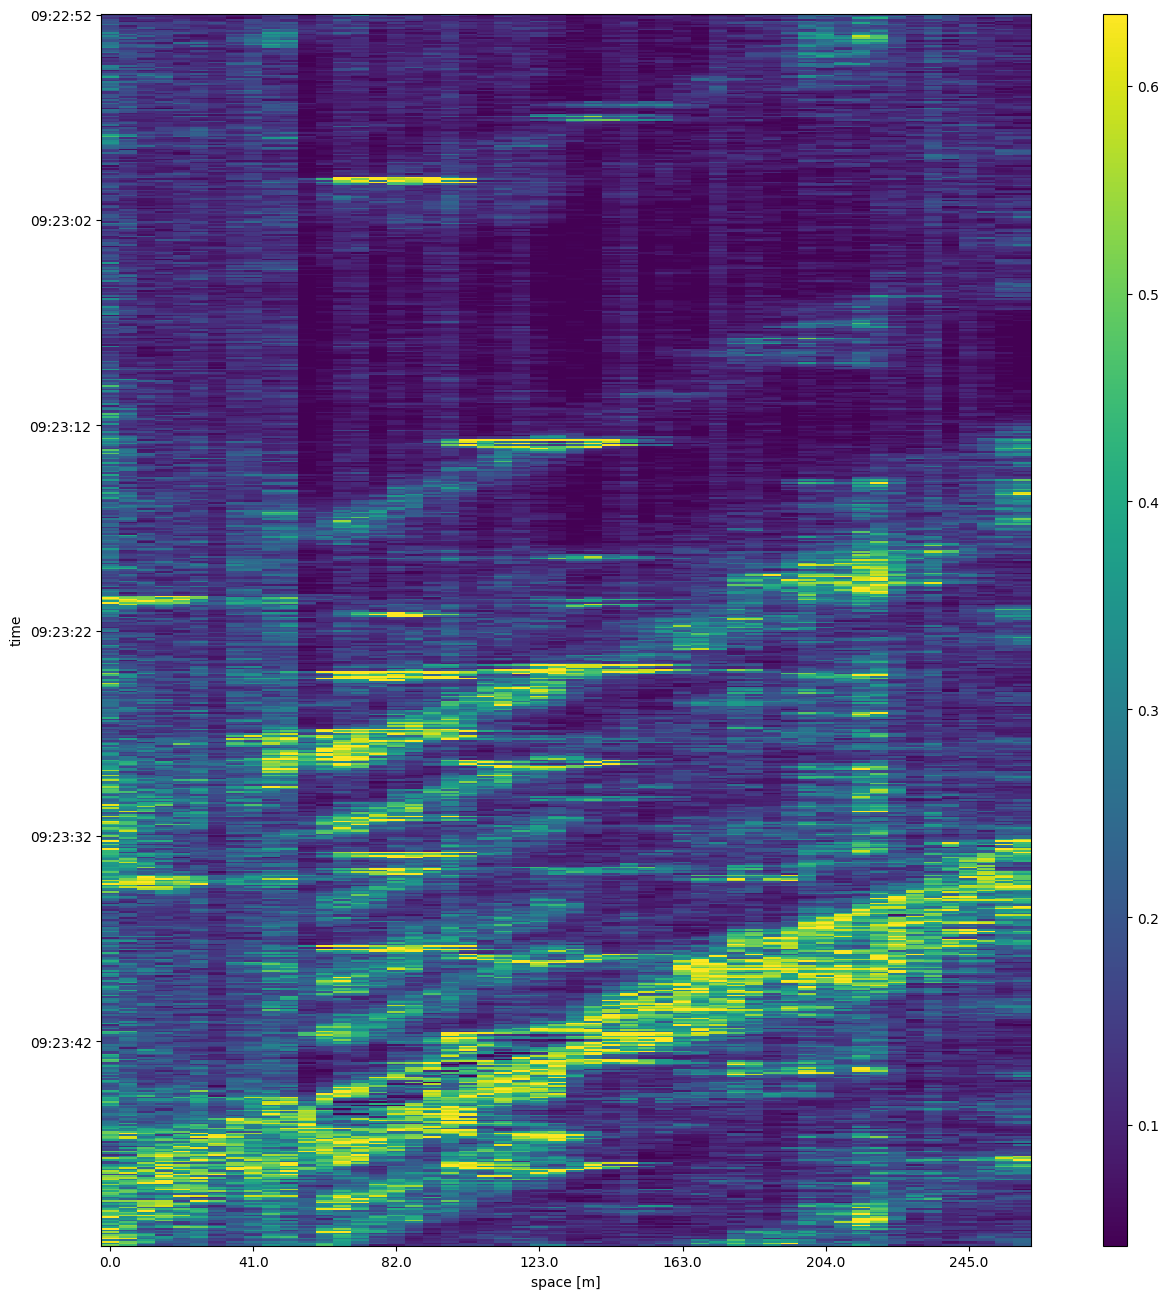

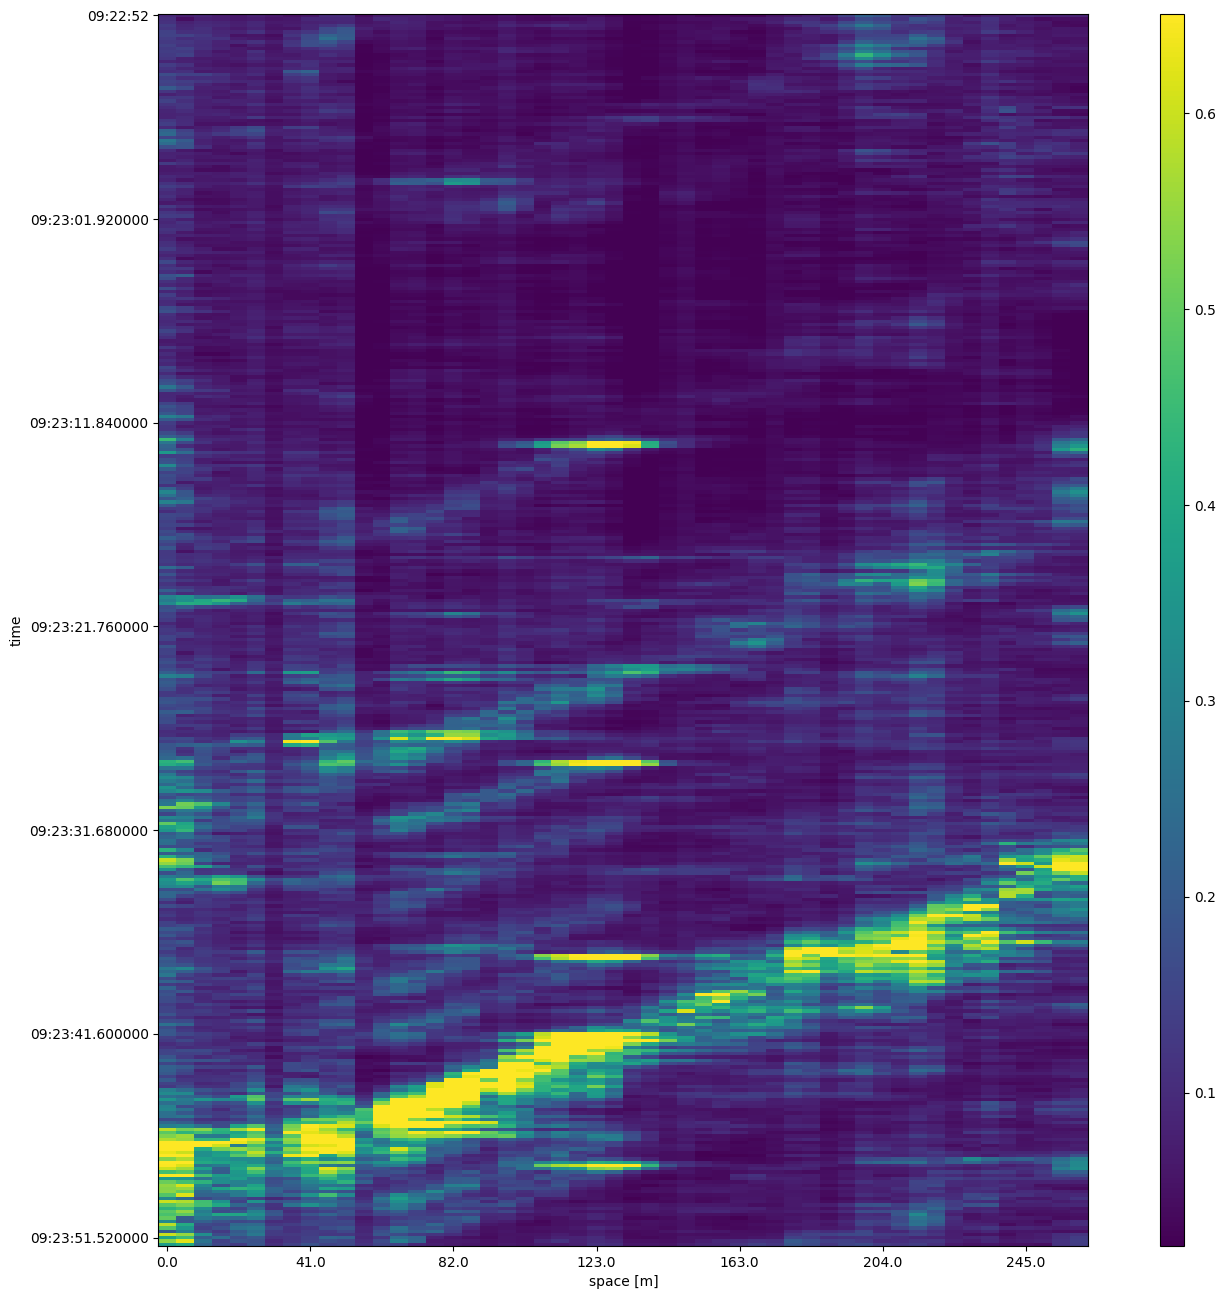

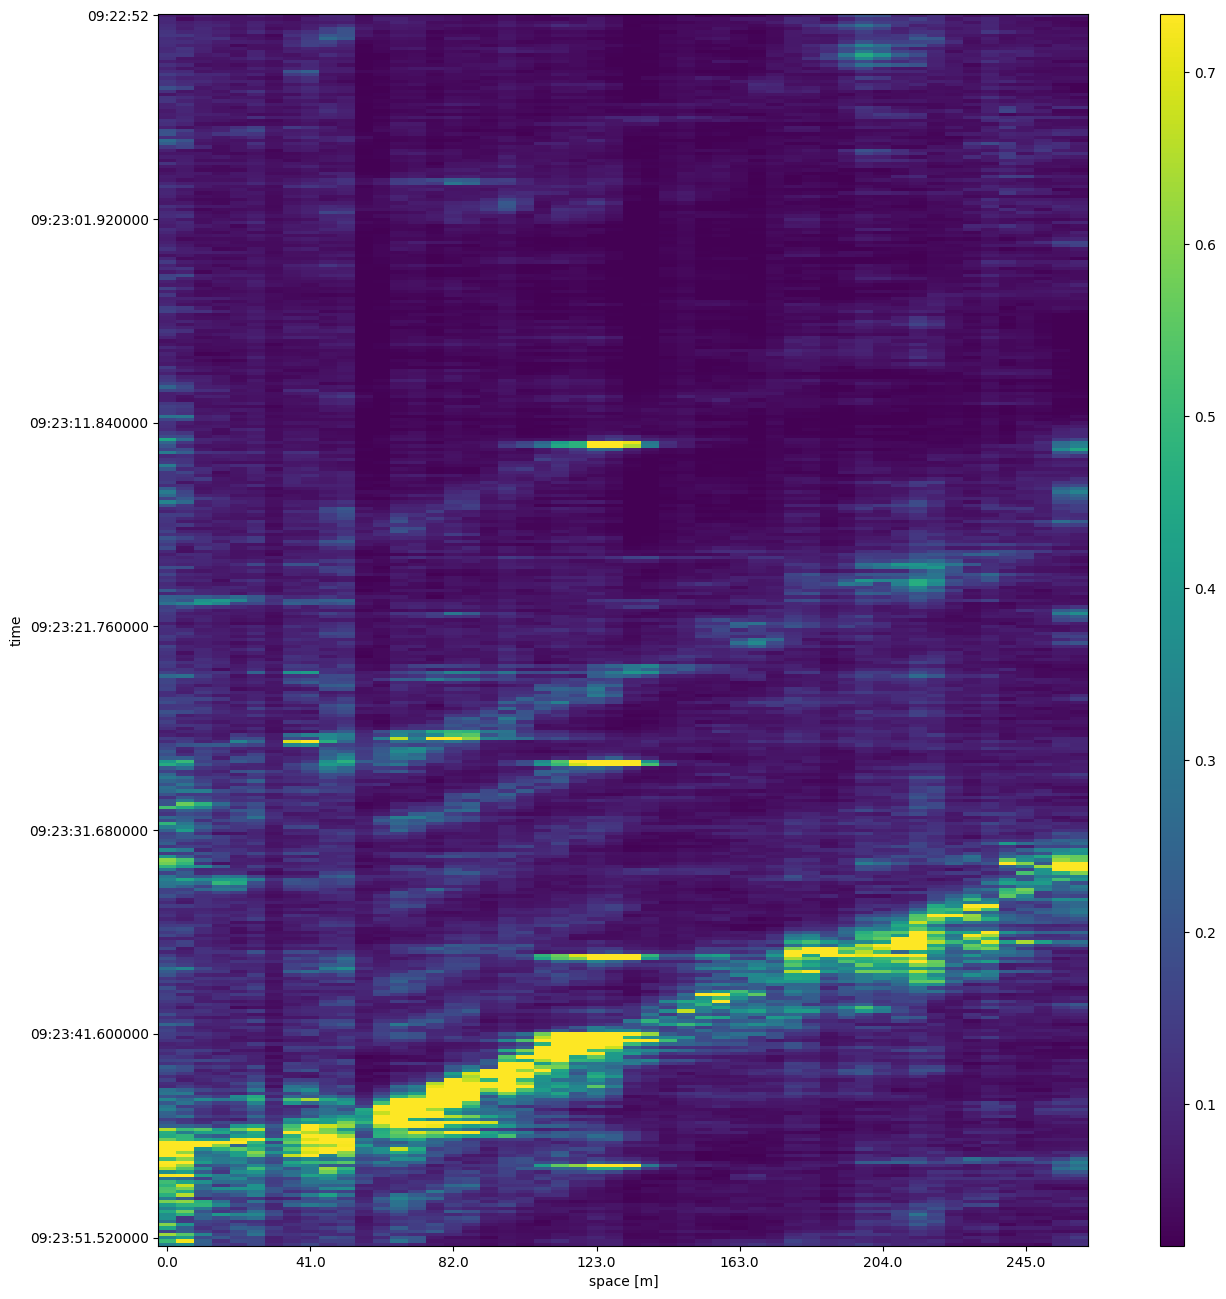

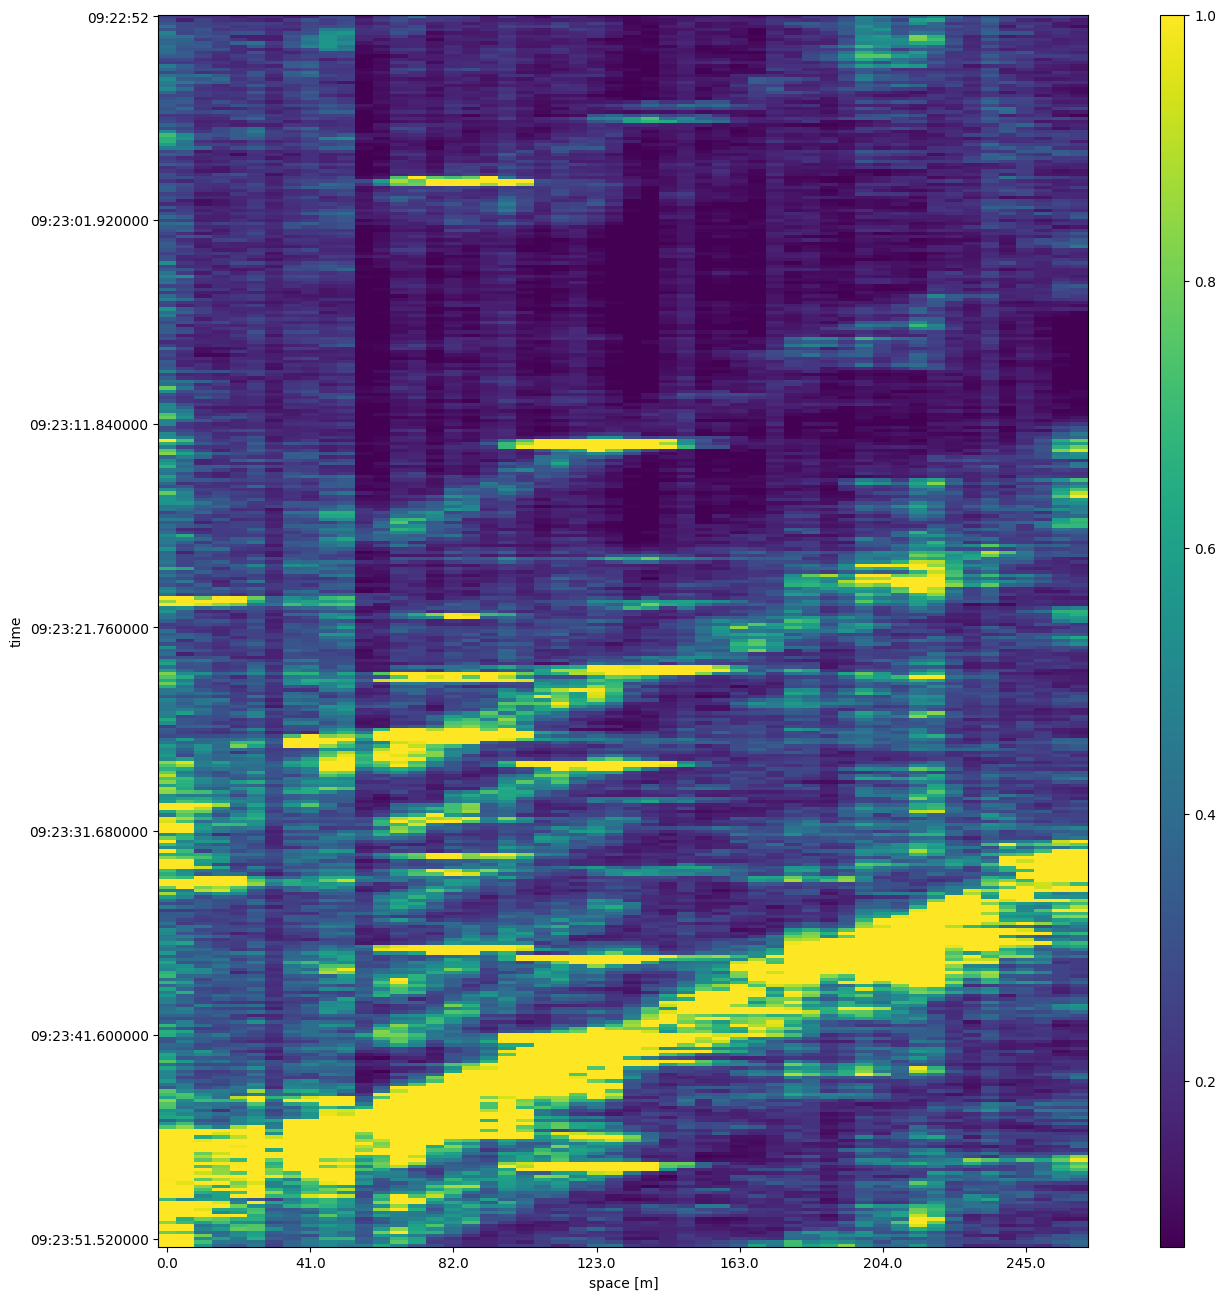

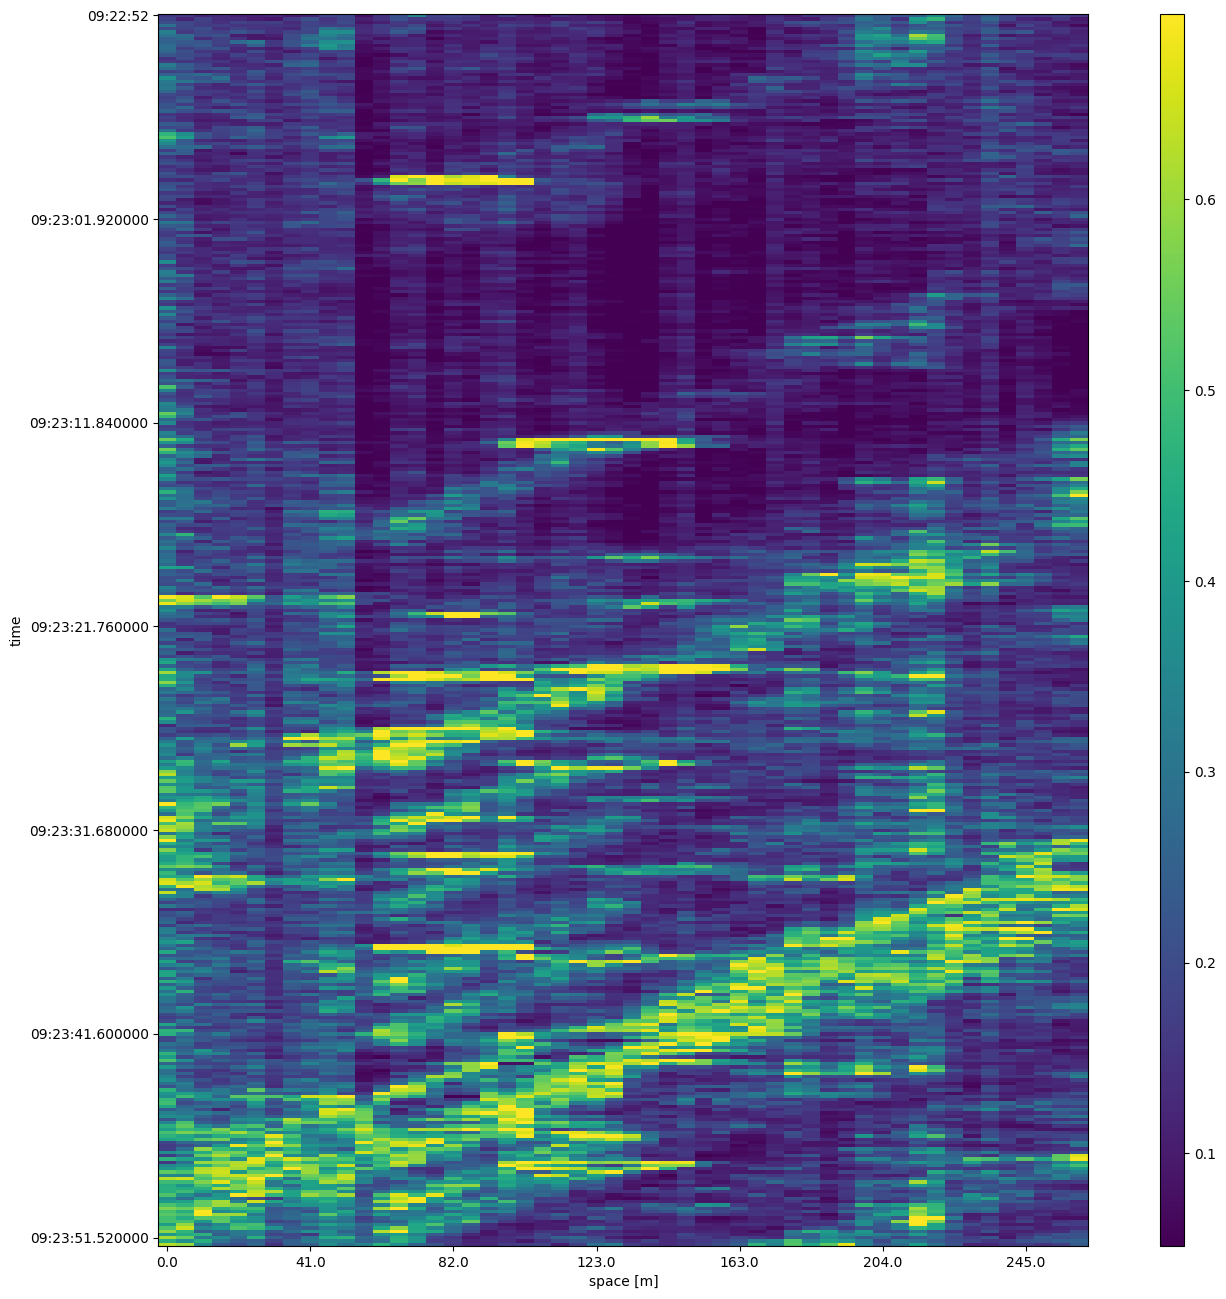

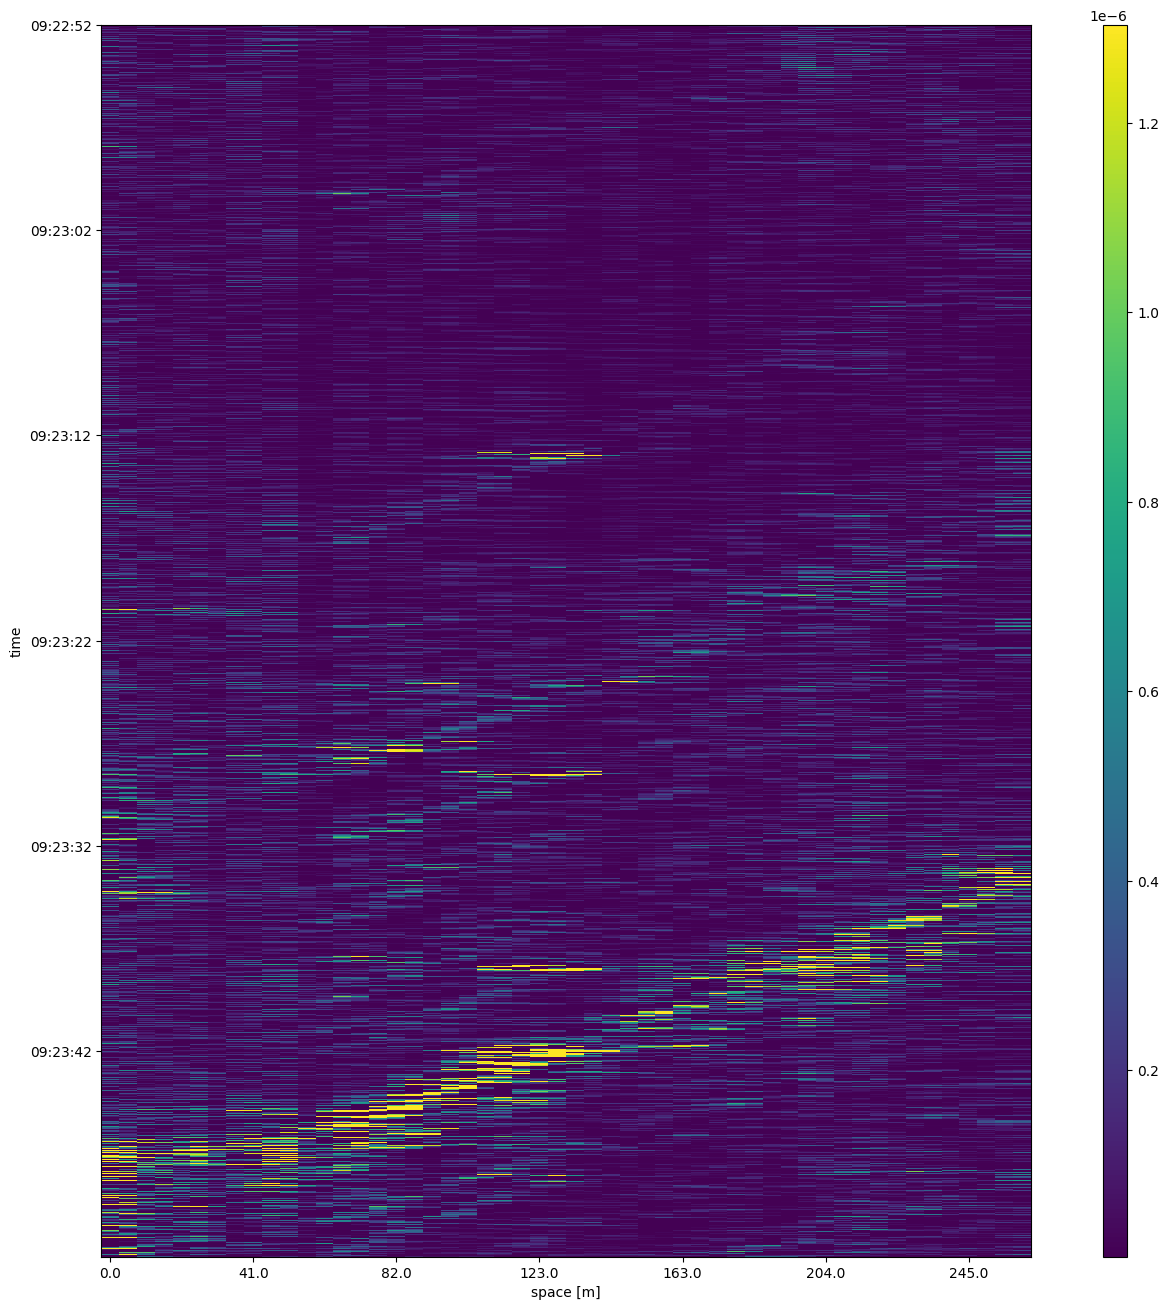

'these filters look kinda promising in compairson to the original picture'

In [160]:
'''here the pixels are aggregated on the vertical axis, since there is huge disproportion betwwen the size of vertical and horizontal axis,
what could pose a problem for the line finding algorithm'''

data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

'''mean downsampling'''
data_1_downsampled = downsampling_time_mean(data_1_preprocessed,50,True)
plotting_function(data_1_downsampled,to_preprocess=False)


data_2_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

'''medain downsampling'''
data_2_downsampled = downsampling_time_median(data_2_preprocessed,50,True)
plotting_function(data_2_downsampled,to_preprocess=False)

data_3_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

'''max downsampling'''
data_3_downsampled = downsampling_time_max(data_3_preprocessed,50,True)
plotting_function(data_3_downsampled,to_preprocess=False)

data_4_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

'''max - mean downsampling'''
data_4_downsampled = downsampling_time_max_mean(data_4_preprocessed,50,True)
plotting_function(data_4_downsampled,to_preprocess=False)


'''the same operations as above but with biggger neighbourhood'''

data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

data_1_downsampled = downsampling_time_mean(data_1_preprocessed,100,True)
plotting_function(data_1_downsampled,to_preprocess=False)


data_2_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

data_2_downsampled = downsampling_time_median(data_2_preprocessed,100,True)
plotting_function(data_2_downsampled,to_preprocess=False)



data_3_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

data_3_downsampled = downsampling_time_max(data_3_preprocessed,100,True)
plotting_function(data_3_downsampled,to_preprocess=False)



data_4_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)

data_4_downsampled = downsampling_time_max_mean(data_4_preprocessed,100,True)
plotting_function(data_4_downsampled,to_preprocess=False)






''''plotting the  normal image  for comparison'''
plotting_function(df_1,True)



'''these filters look kinda promising in compairson to the original picture'''

#### thresholding application

In [161]:
'''trying converting to (0,255) scale in order to make use of some ready solutions from opencv that work on images'''

# data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
# data_1_converted = convert_to_img_format(data_1_preprocessed,True)
# #lost some minor information probably since x =  floor(225*x)
# plotting_function(data_1_converted,False)

# '''trying the otsu  threshold the normal image therefore'''
# data_1_thresholded = thresholding_otsu_function(data_1_converted)
# '''otsu seem to have lost quite a gret deal of lines'''

# plotting_function(data_1_thresholded,False)


# '''adaptive thresholding on the other hand seem to have produced to many positive results'''
# data_2_thresholded = thresholding_adaptive_function(data_1_converted)
# plotting_function(data_2_thresholded)


# '''another adaptive threshold , but yields similar effect to the previous'''
# data_3_thresholded = thresholding_adaptive_gaussian_function(data_1_converted)
# plotting_function(data_3_thresholded)






    

'trying converting to (0,255) scale in order to make use of some ready solutions from opencv that work on images'

In [162]:
'''therefore maybe trying with tweaking the adaptive thresholding constant, to be more rigorous'''
''' commented due to lengthy output'''
# for constant in list(range(-50,-2,10)):
    
#     data_1_thresholded= thresholding_adaptive_function(data_1_converted,101,constant)
#     plotting_function(data_1_thresholded)
'''wasnt especially promising'''

'wasnt especially promising'

In [163]:
'''therefore maybe trying with tweaking the adaptive thresholding constant, to be more rigorous'''
'''commented due to lengthy output'''
# for constant in list(range(-50,-2,10)):
#     data_2_thresholded= thresholding_adaptive_gaussian_function(data_1_converted,101,constant)
#     plotting_function(data_2_thresholded)





'commented due to lengthy output'

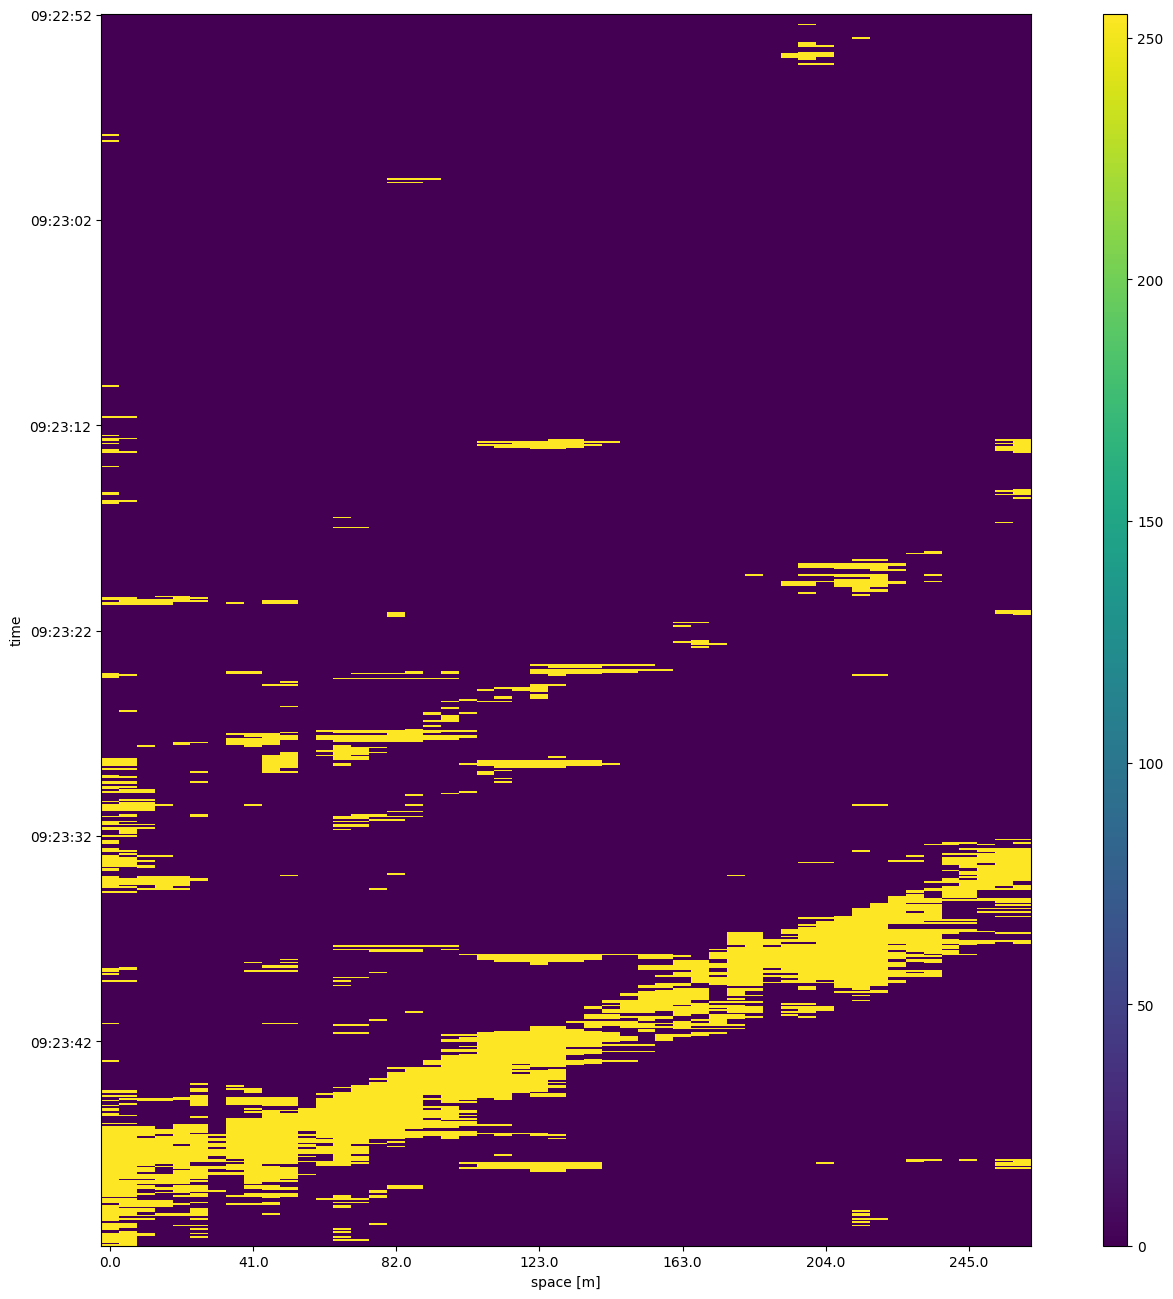

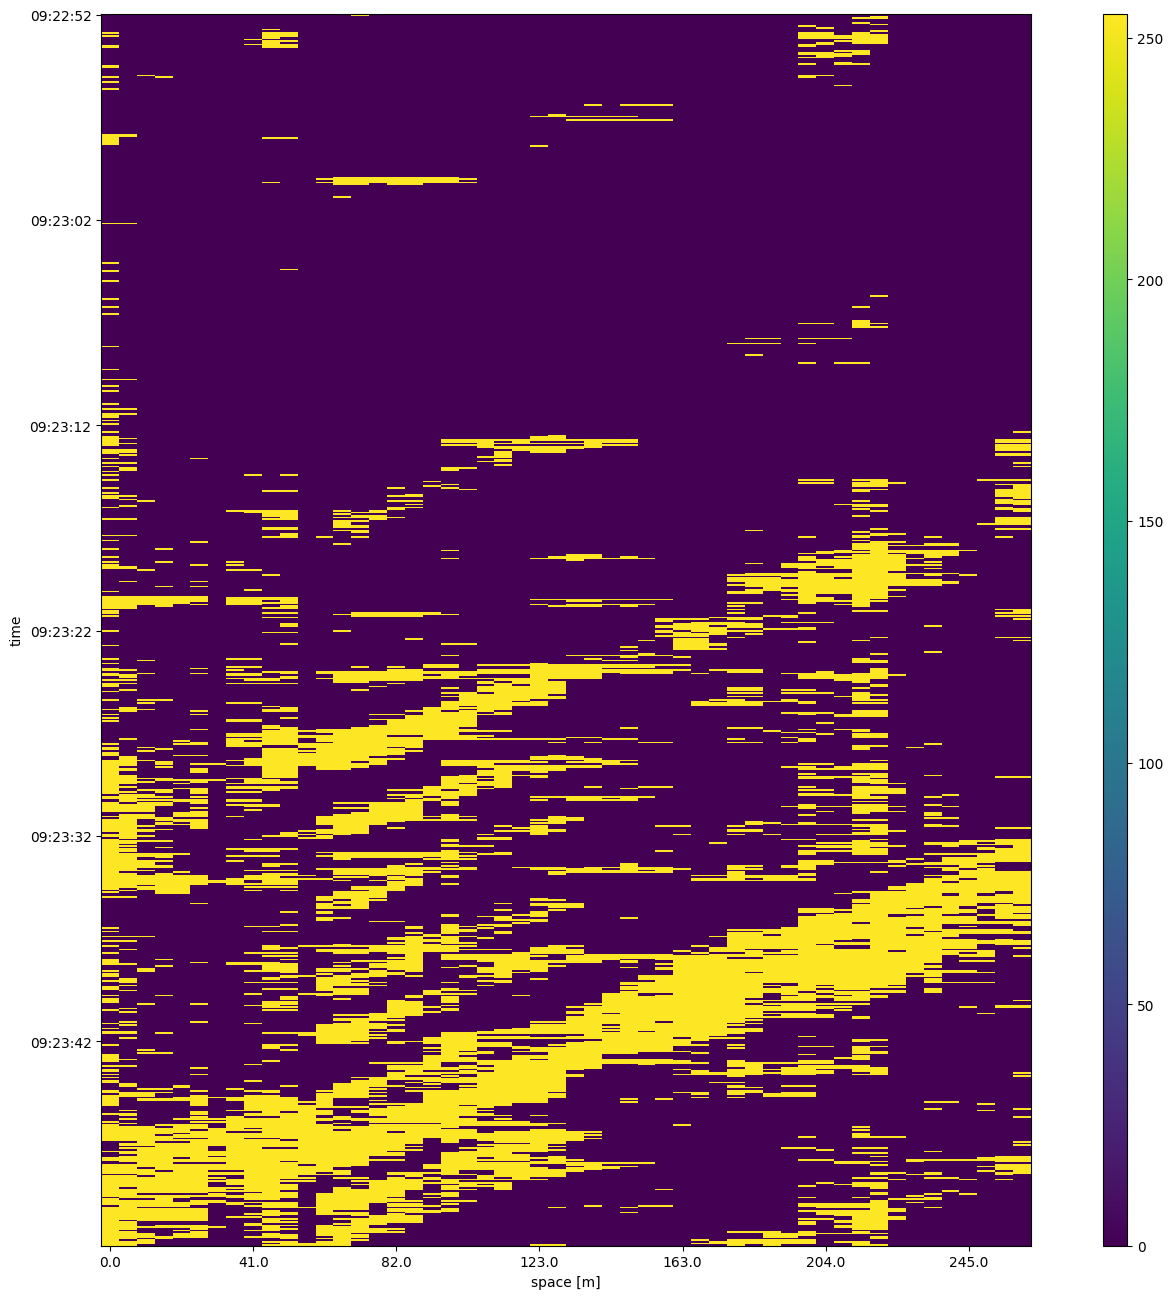

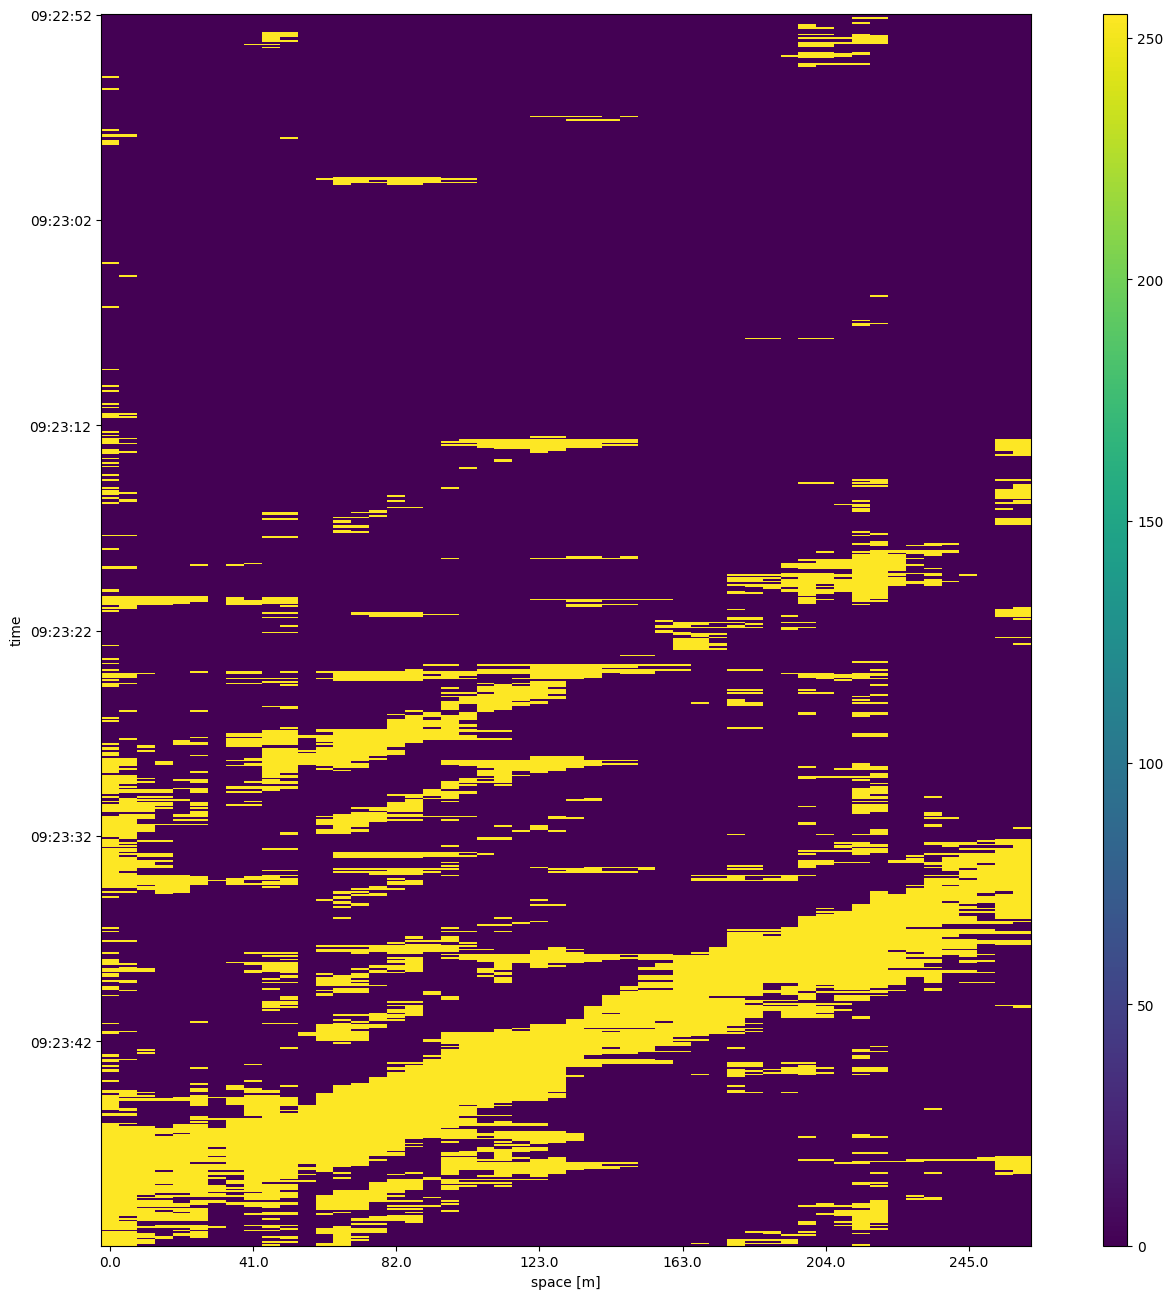

In [164]:
'''now trying to combine the thresholding with the time downsample by aggregation'''
data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean downsampling taking place, however it doesnt seem to have any great effect'''
data_1_downsampled = downsampling_time_mean(data_1_preprocessed,50,True)
data_1_converted = convert_to_img_format(data_1_downsampled,True)

data_1_thresholded_otsu = thresholding_otsu_function(data_1_converted,True)
plotting_function(data_1_thresholded_otsu,to_preprocess=False)


'''the max_mean downsampling, seem to look much better '''
data_2_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
data_2_downsampled = downsampling_time_max_mean(data_2_preprocessed,50,True)
data_2_converted = convert_to_img_format(data_2_downsampled,True)

data_2_thresholded_otsu = thresholding_otsu_function(data_2_converted,True)
plotting_function(data_2_thresholded_otsu,to_preprocess=False)



'''the max downsampling, seem to be worse than the max_mean '''
data_3_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
data_3_downsampled = downsampling_time_max(data_3_preprocessed,50,True)
data_3_converted = convert_to_img_format(data_3_downsampled,True)

data_3_thresholded_otsu = thresholding_otsu_function(data_3_converted,True)
plotting_function(data_3_thresholded_otsu,to_preprocess=False)






In [165]:
'''now trying combining the best looking downsampling with the adsaptive threshold binarization, '''
# for constant in list(range(-50,-2,10)):
    
#      data_2_thresholded_adaptive = thresholding_adaptive_function(data_2_converted,101,constant,True)
#      plotting_function(data_2_thresholded_adaptive,to_preprocess=False)

'''but it didnt yield any great results'''


'but it didnt yield any great results'

<class 'pandas.core.frame.DataFrame'>


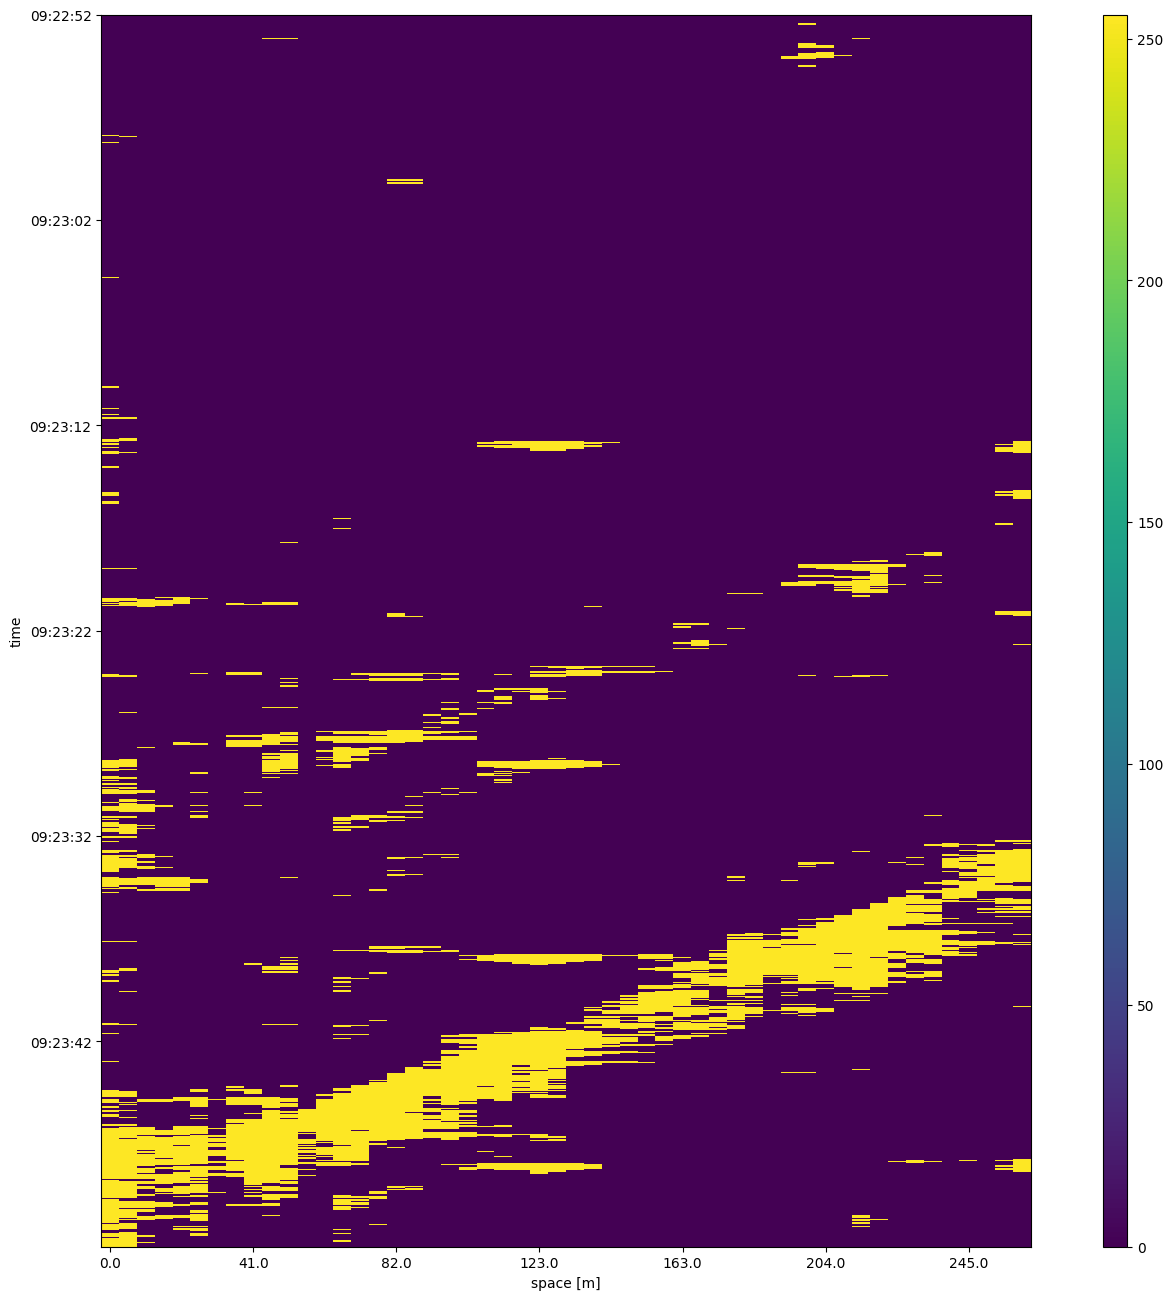

'not looking too good'

In [166]:
'''now instead of downsampling , the mean for vertical neighbourhood for  each pixel in the retained original image size combined with thresholding'''

data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the vertical mean blurring taking place,cobined with converting to 0-255 and thresholding otsu'''
data_1_blurred = blurring_function(data_1_preprocessed,(50,1),False,True)


data_1_converted = convert_to_img_format(data_1_blurred,True)

data_1_thresholded_otsu = thresholding_otsu_function(data_1_converted,True)
plotting_function(data_1_thresholded_otsu,to_preprocess=False)
'''not looking too good'''


In [167]:
'''adaptive thresholding with this vertical axis means'''
# for constant in list(range(-50,-2,10)):
    
#      data_1_thresholded_adaptive = thresholding_adaptive_function(data_1_converted,101,constant,True)
#      plotting_function(data_1_thresholded_adaptive,to_preprocess=False)
''''and adaptive thresholding for this mean aggregation again doesnt look that good '''

"'and adaptive thresholding for this mean aggregation again doesnt look that good "

#### Morphologic operations testing

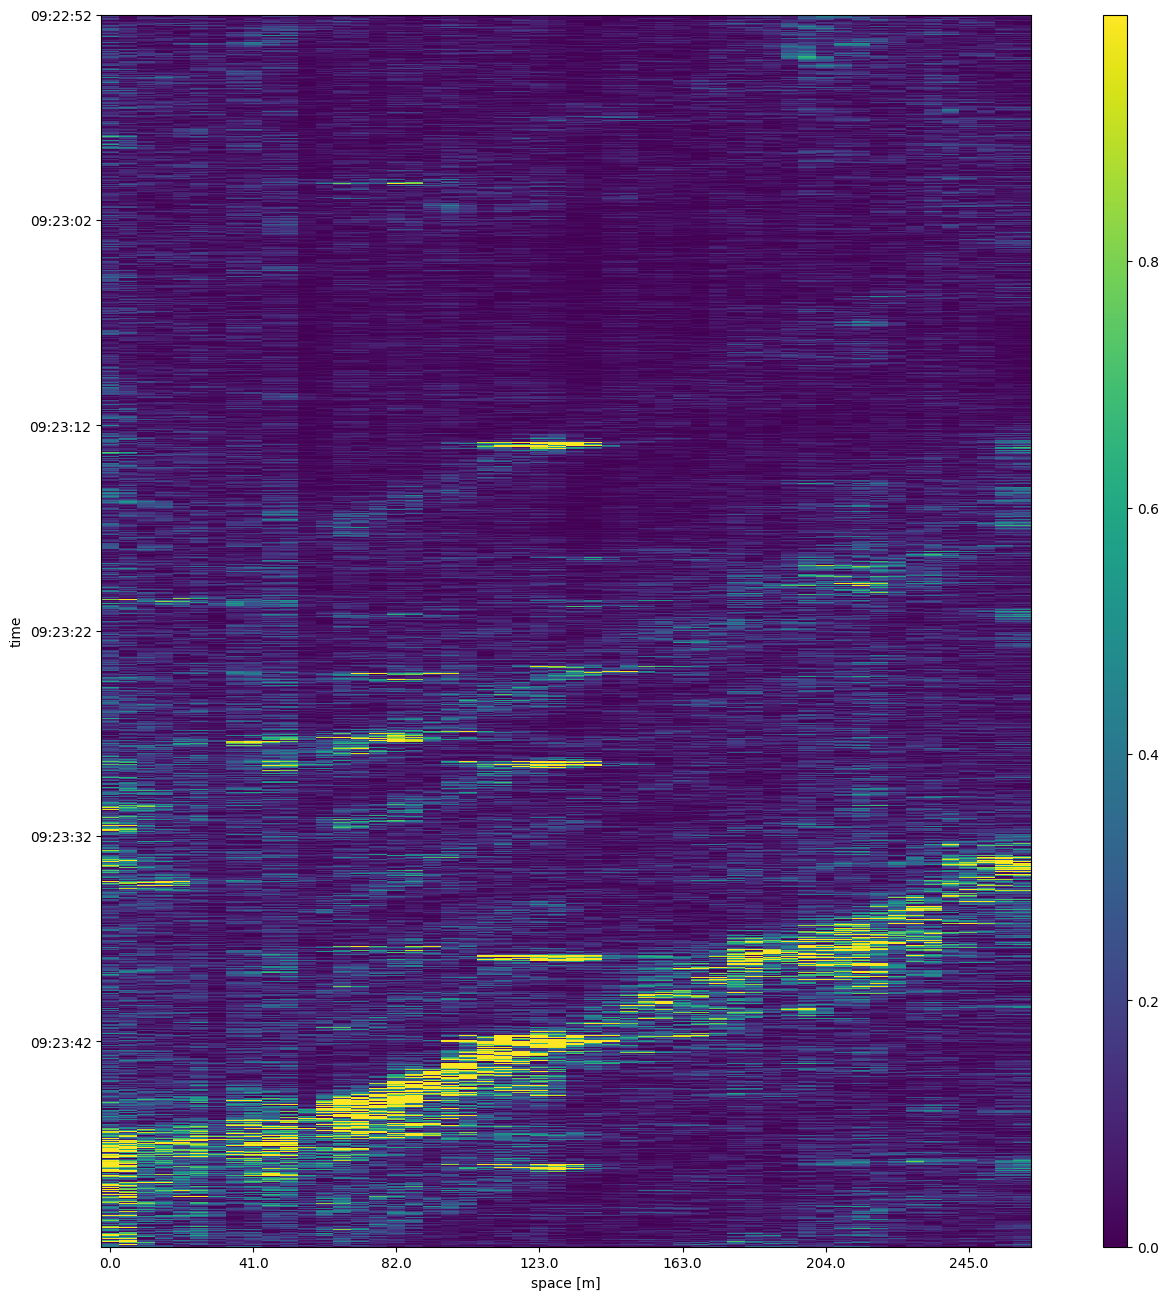

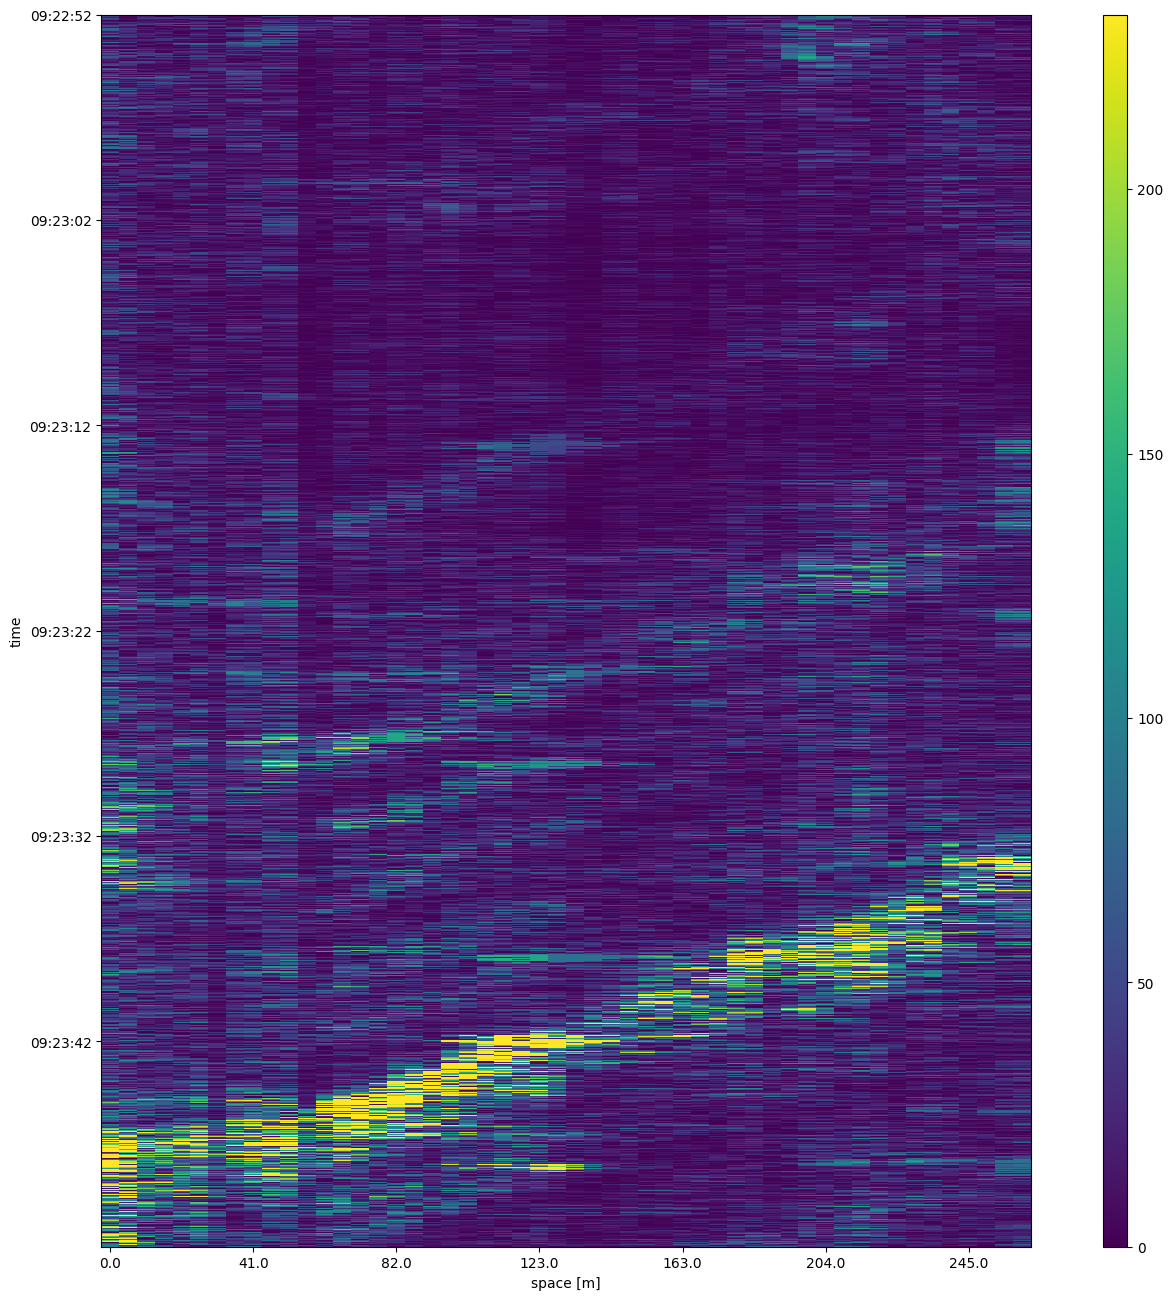

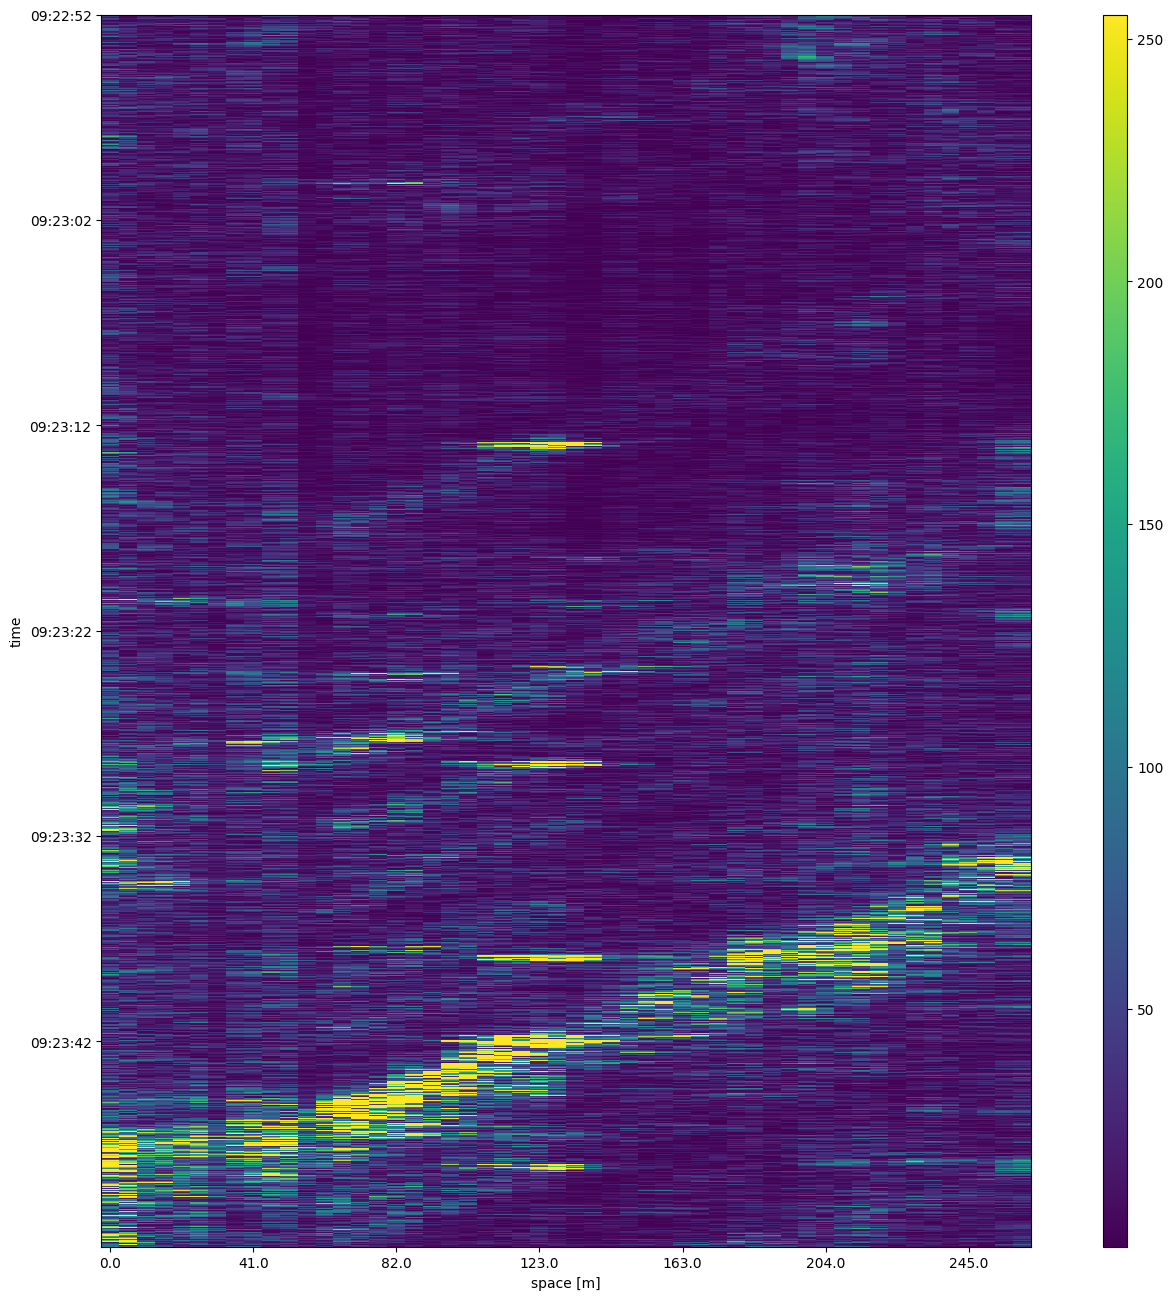

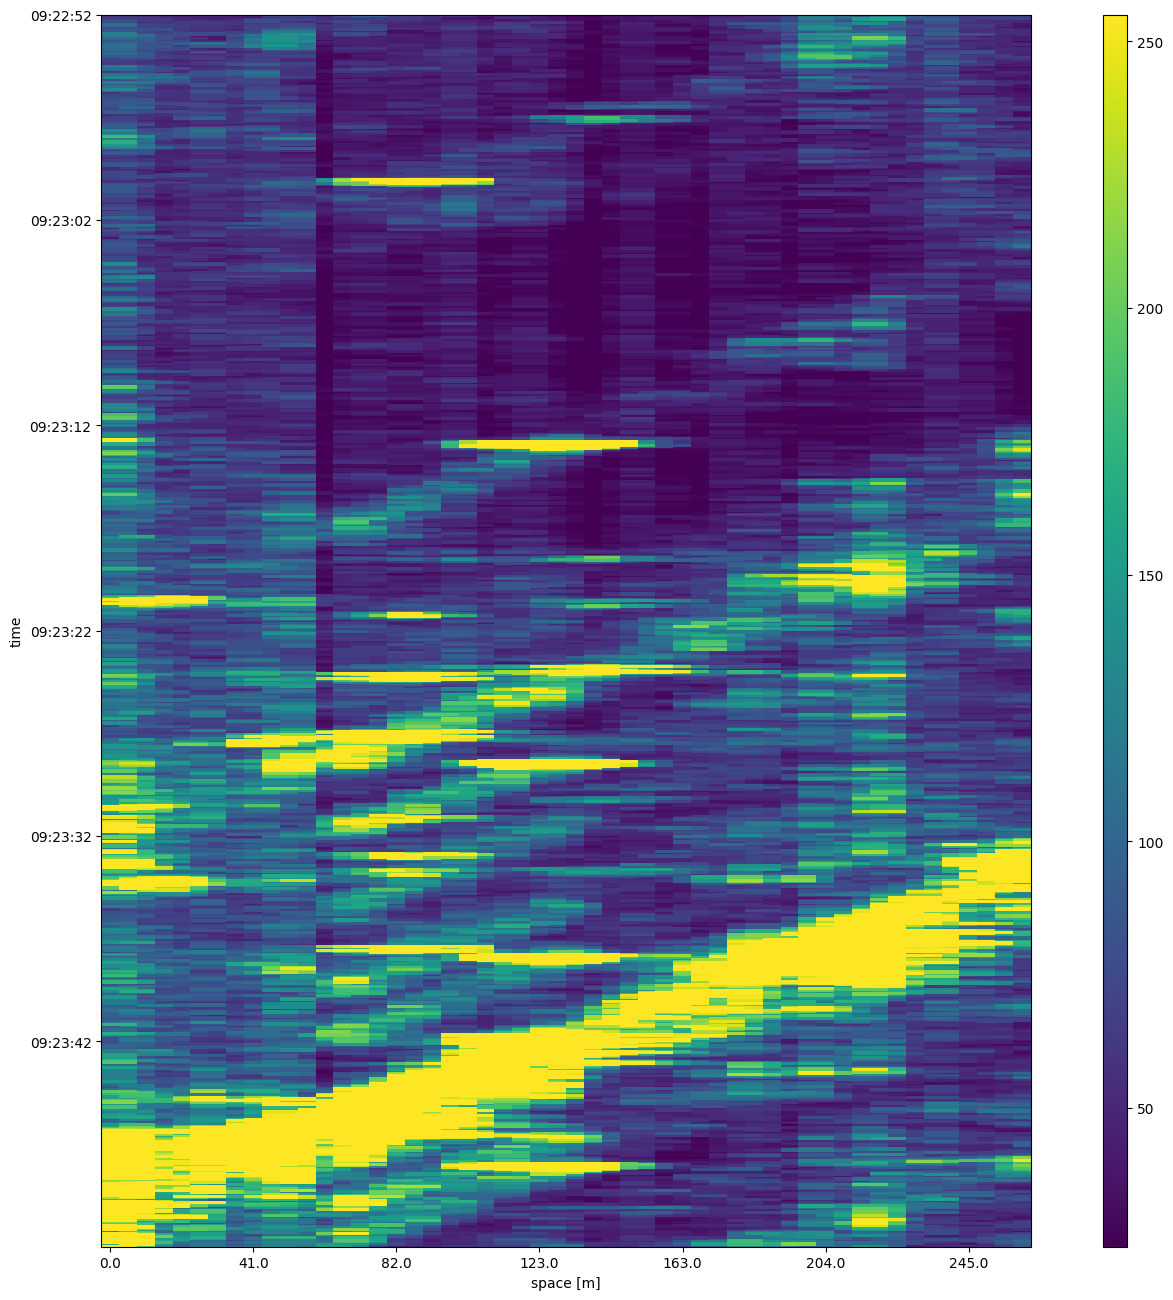

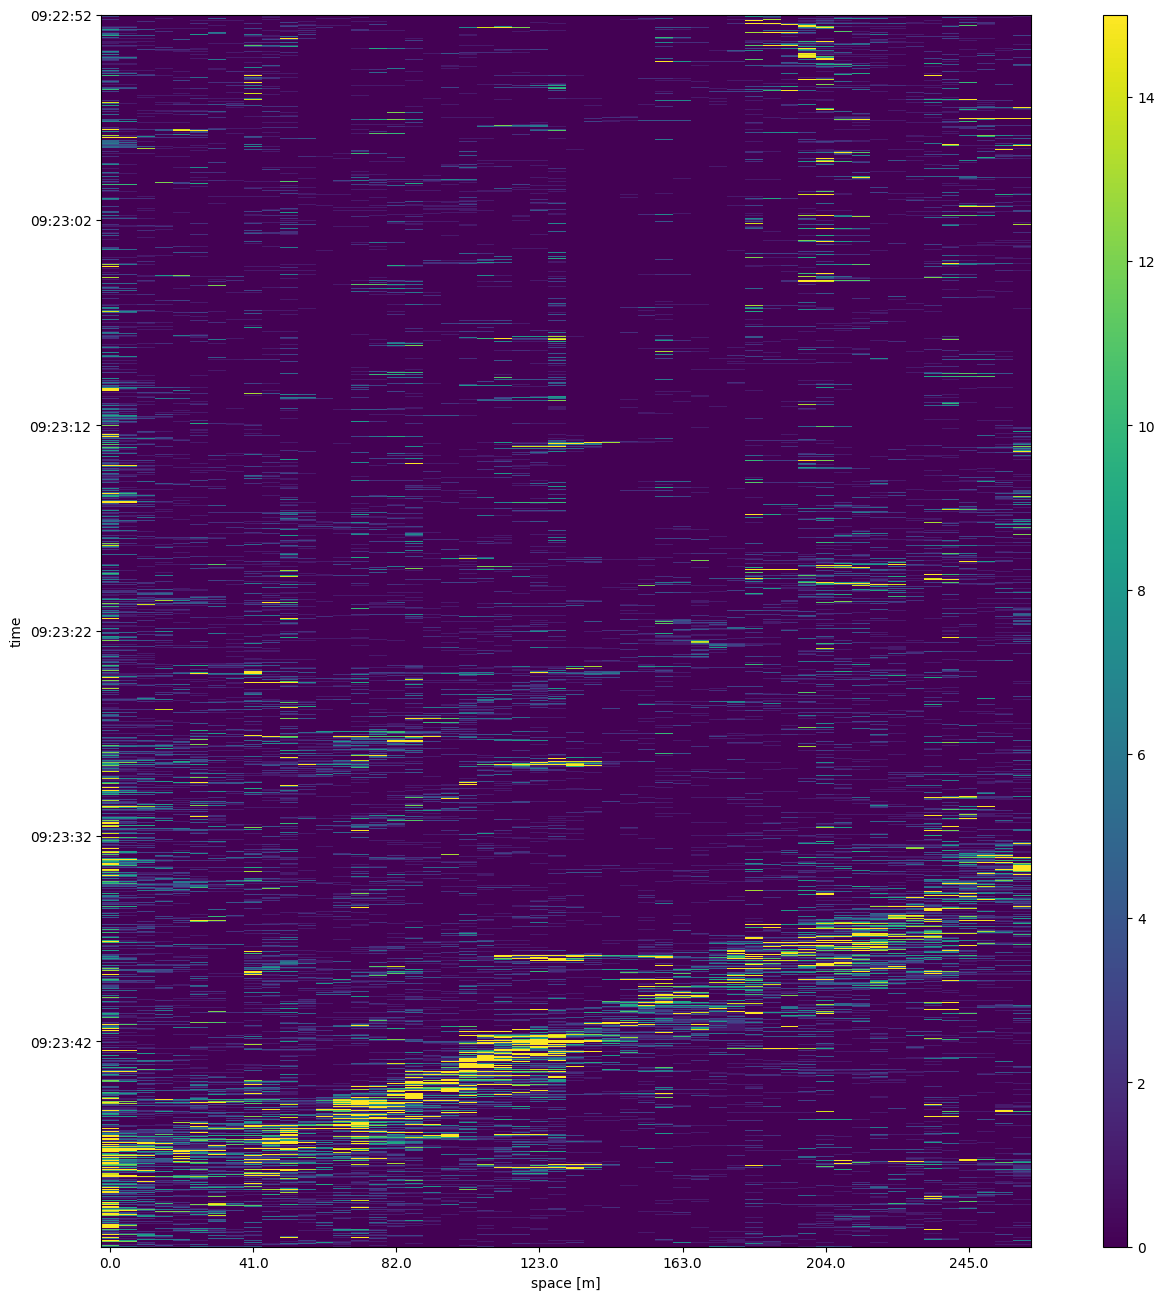

'None of these outputs looks truly interesting, maybe dilation only??'

In [168]:
'''first checking the effect on the image of the basic morphologic operations only with the basic preprocessing, 
not interesting outcomes unfortunately'''
data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
plotting_function(data_1_preprocessed,False)

data_1_converted = convert_to_img_format(data_1_preprocessed)



'''looks even worse'''
data_1_opened = proper_opening(data_1_converted,(1000,3),ret_dataframe=True)
plotting_function(data_1_opened,False)


'''not really much difference seen'''
data_1_closed = proper_closing(data_1_converted,(5,5),ret_dataframe=True)
plotting_function(data_1_closed,False)


# data_1_automedian = automedian(data_1_converted,[50],ret_dataframe=True)
# plotting_function(data_1_automedian)
'''might be promising somehow'''
data_1_dilation = continous_dilation(data_1_converted,np.array((100,2)),ret_dataframe=True)
plotting_function(data_1_dilation)

'''might be promising but maybe combined with dilation?'''
data_1_erosion = continous_erosion(data_1_converted,np.array((20,2)),ret_dataframe=True)
plotting_function(data_1_erosion)


'''None of these outputs looks truly interesting, maybe dilation only??'''

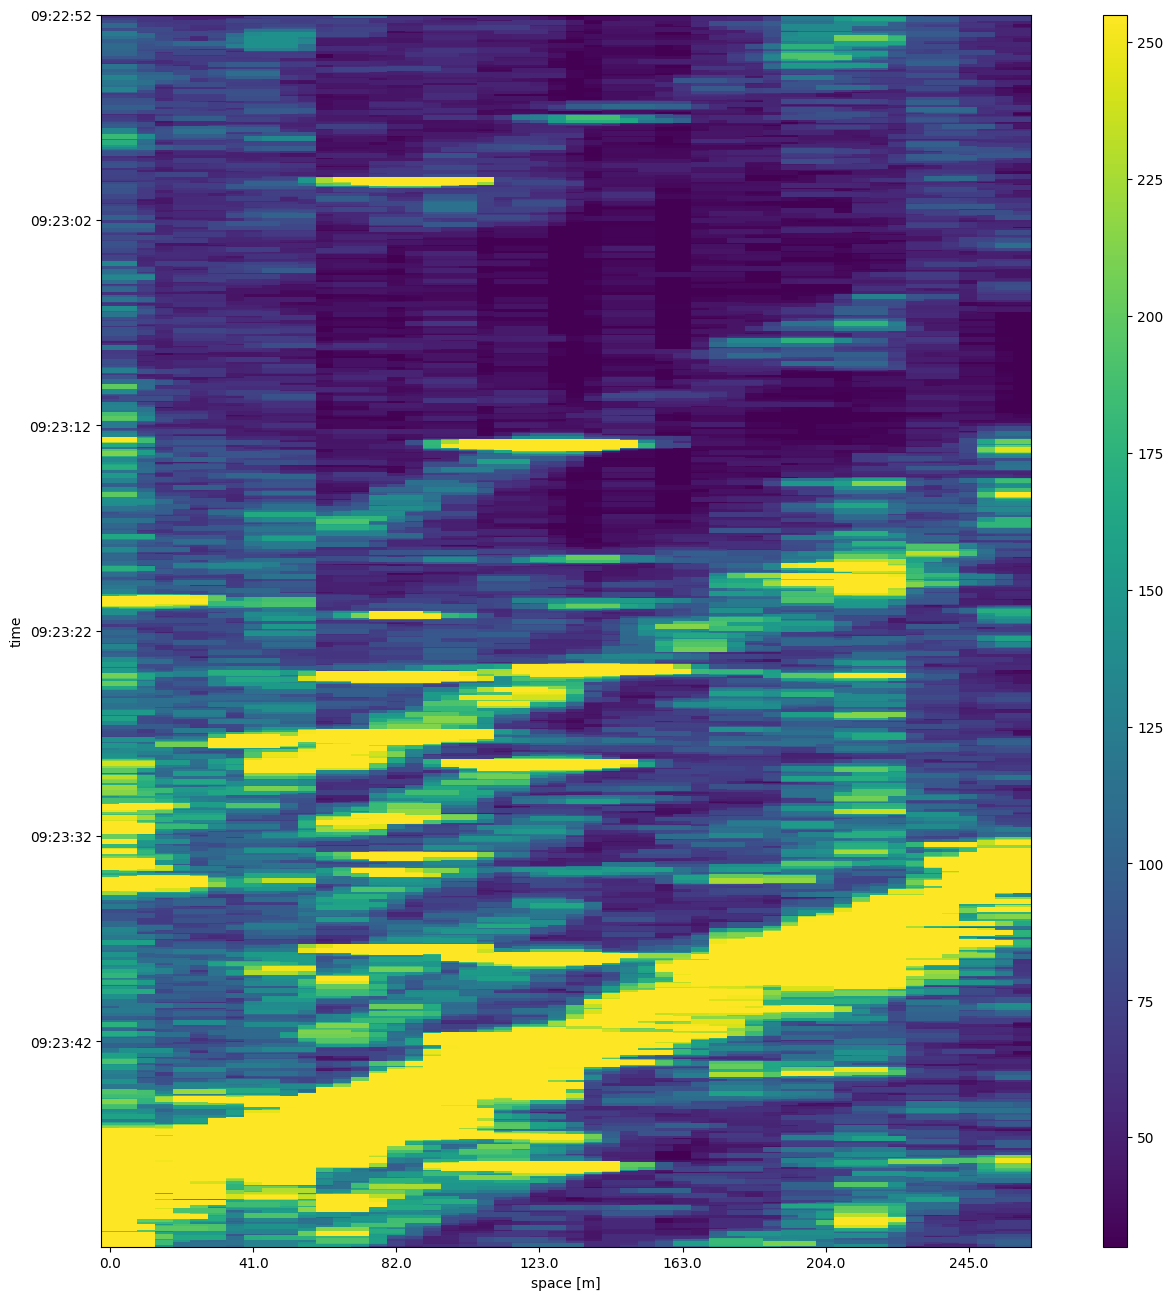

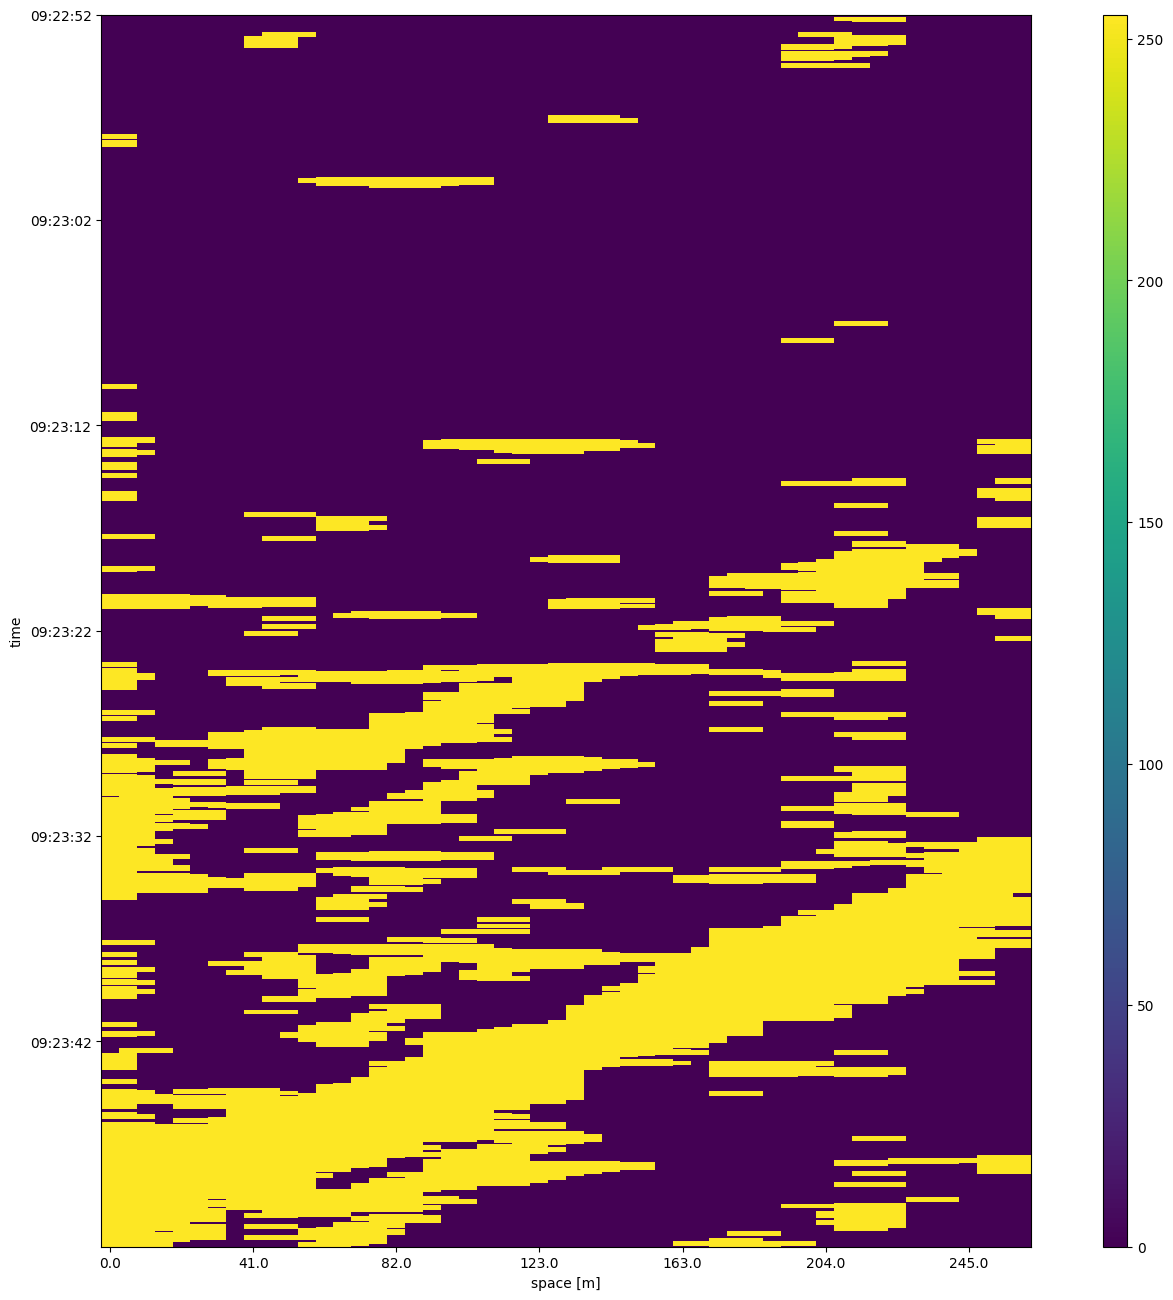

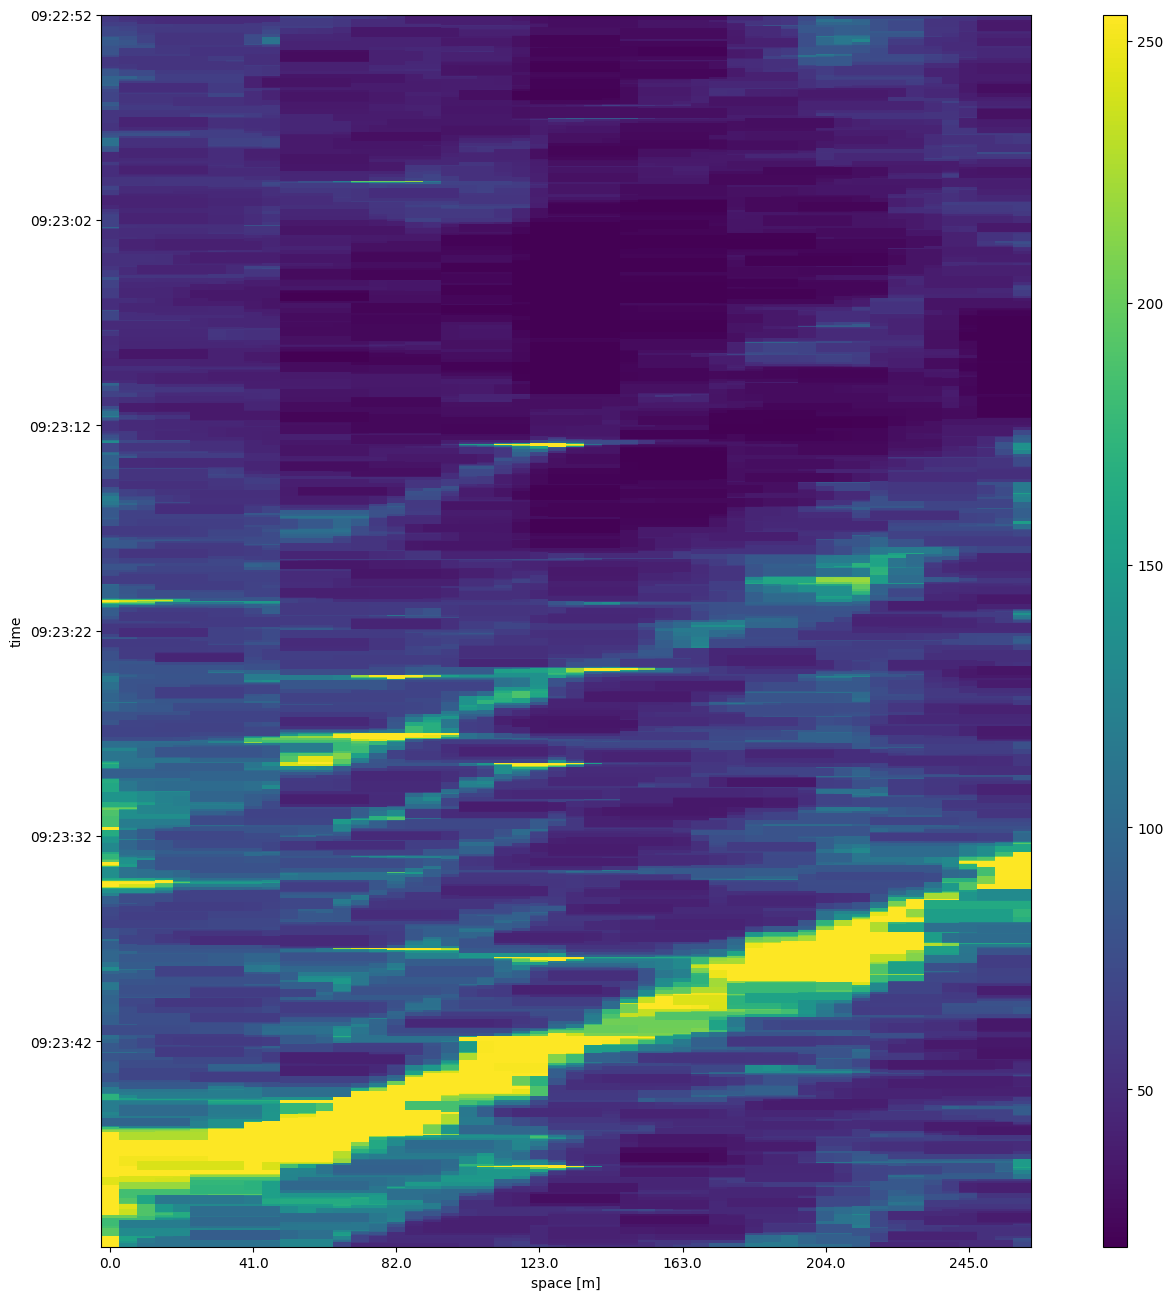

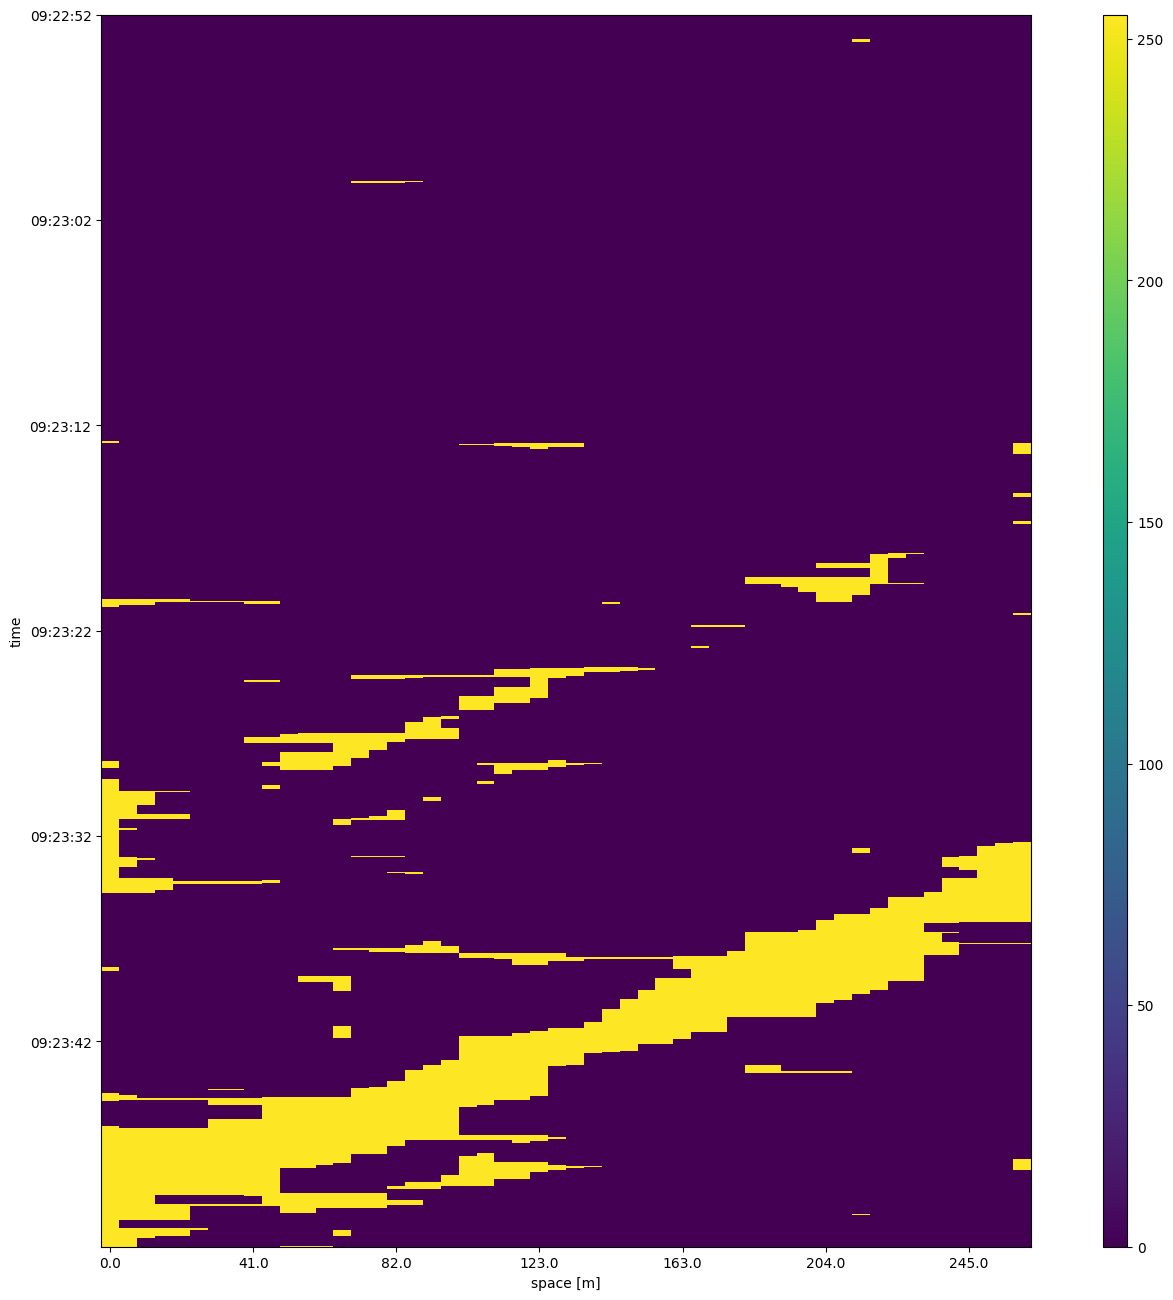

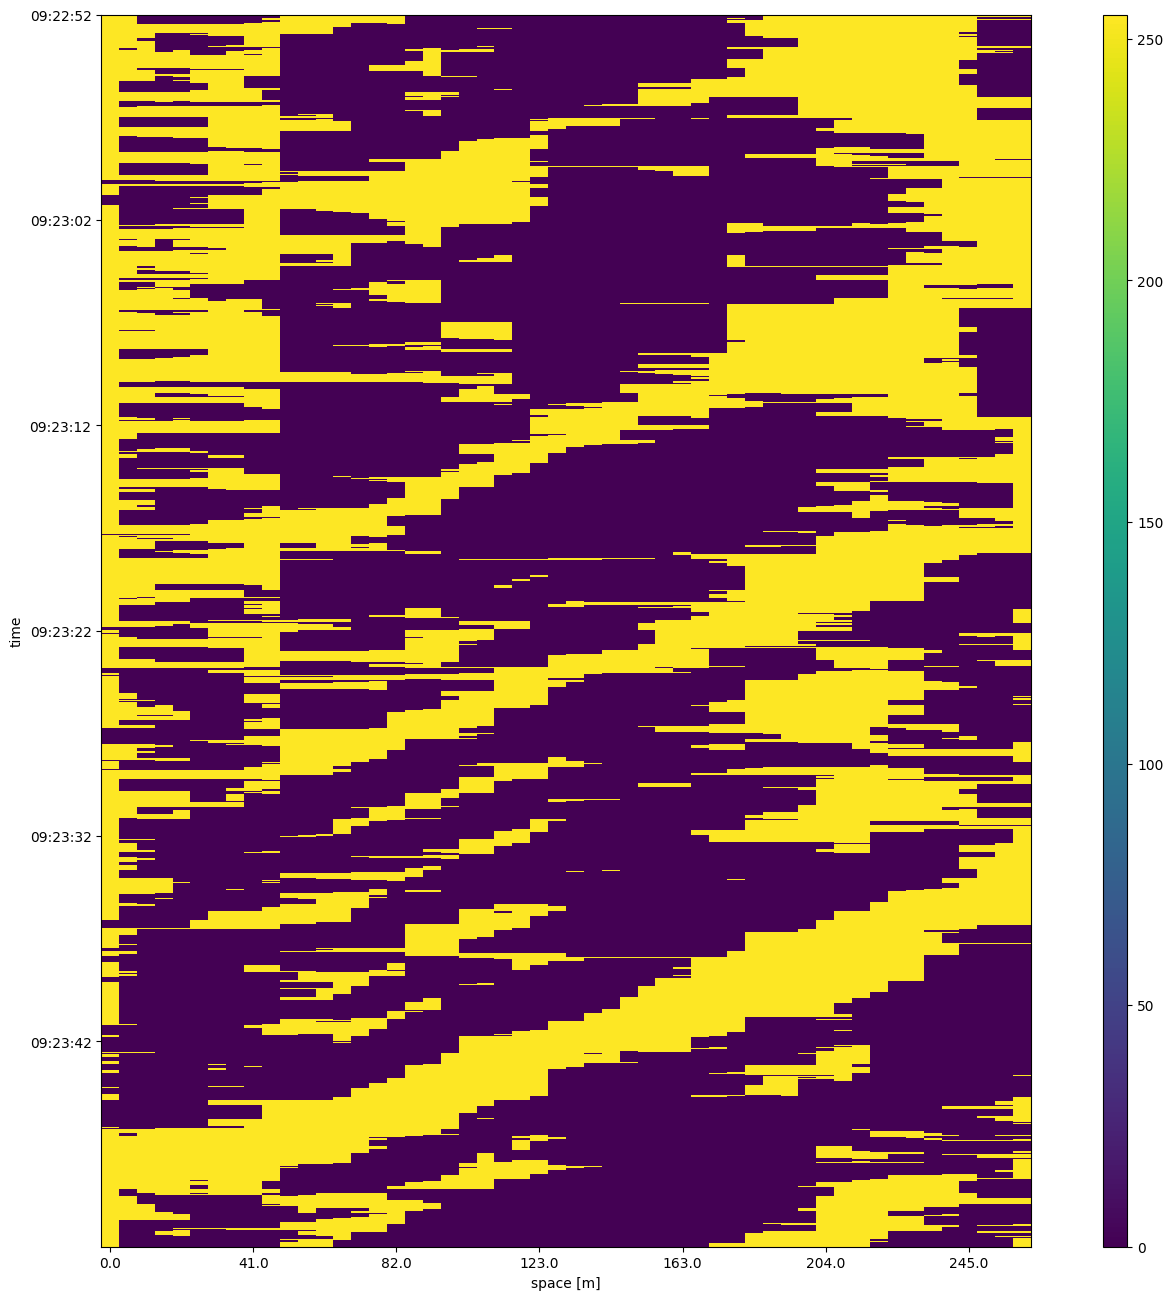

'otsu on dilation does not look bad, but not better than earlier otsu on dowsnampling'

In [169]:
''' More testing'''
'''trying combining morphologic operations with thresholding'''
data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
data_1_dilation = continous_dilation(data_1_converted,np.array((150,3)),ret_dataframe=True)
plotting_function(data_1_dilation)
data_1_otsu = thresholding_otsu_function(data_1_dilation,True)
plotting_function(data_1_otsu)

data_1_erosion = continous_erosion(data_1_dilation,np.array((250,5)))
plotting_function(data_1_erosion)
data_2_otsu = thresholding_otsu_function(data_1_erosion,True)
plotting_function(data_2_otsu)

data_2_adaptive = thresholding_adaptive_gaussian_function(data_1_erosion)
plotting_function(data_2_adaptive)
# kern = create_diag_kernel((50,2))
# data_1_erosion = continous_erosion(data_1_dilation,kern,True)
# plotting_function(data_1_erosion)
# data_2_erosion =continous_erosion(data_1_erosion,kern,True)
# plotting_function(data_2_erosion)

# data_2_otsu = thresholding_otsu_function(data_2_erosion)
# plotting_function(data_2_otsu)

'''otsu on dilation does not look bad, but not better than earlier otsu on dowsnampling'''


In [170]:
''''further trying to combine the dilation and erosion for number of iterations, but not realy interesting output'''
# data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
# data_1_converted = convert_to_img_format(data_1_preprocessed,True)
# kern = create_diag_kernel((50,2))
# data_1_dilation = continous_dilation(data_1_converted,kern,True)
# plotting_function(data_1_dilation)

# kern_2 = create_diag_kernel((50,1))
# data_1_erosion = continous_erosion(data_1_dilation,kern_2,True)
# plotting_function(data_1_erosion)


# for i in range(10):  
#     data_1_erosion = continous_erosion(data_1_erosion,kern_2,True)
#     plotting_function(data_1_erosion)


# kern_3 = create_diag_kernel((20,2))
# data_1_dilation = continous_dilation(data_1_erosion,kern_3,True)
# for i in range(10):
#     data_1_dilation = continous_dilation(data_1_dilation,kern_3,True)
#     plotting_function(data_1_dilation)
#     threshold_1_otsu = thresholding_otsu_function(data_1_dilation,True)
#     plotting_function(threshold_1_otsu)
    







'''nothing really interesting here it seems'''


'nothing really interesting here it seems'

In [177]:
def imshow(img, num=1):
    cv2.imshow('ImageWindow', cv2.resize(img, (256*num, 512), interpolation=cv2.INTER_LINEAR))
    cv2.waitKey()
    cv2.destroyAllWindows()

def hough(img, rho=10, threshold=50, mll=100, mlg=20):
    c_test_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    c_test_img_p = np.copy(c_test_img)

    lines = cv2.HoughLines(img, 1, np.pi / 180, 150, None, 0, 0)
        
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(c_test_img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

    linesP = cv2.HoughLinesP(img, rho, np.pi / 180, threshold, None, mll, mlg)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(c_test_img_p, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

    # imshow(test_img)
    # imshow(c_test_img)
    imshow(np.concatenate([cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), c_test_img, c_test_img_p], axis=1), 3)

test_img = np.array(data_2_thresholded_otsu)
hough(test_img, rho=10, threshold=50, mll=150, mlg=20)


struct = np.ones((3, 3), np.uint8)
test_img_erode = cv2.erode(test_img, struct, iterations=1)

hough(test_img_erode, rho=20, threshold=50, mll=100, mlg=50)